# Модули

In [1]:
import os
import math
import xlwt
import xlrd
import glob
import datetime
import openpyxl
import xlsxwriter

from lmfit import Model
from struct import unpack
from collections import deque
from copy import copy, deepcopy
from openpyxl import load_workbook
from scipy.optimize import curve_fit
from datetime import datetime, date, time
from lmfit.models import GaussianModel, PowerLawModel, LognormalModel


import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from numpy import random, mean, var, std, median,arange
from IPython import get_ipython
from matplotlib import mlab
import matplotlib.ticker as ticker

from astropy.utils import iers
from astropy.time import Time, TimeDelta
from astropy.coordinates import Angle
from astropy import units as u
from bisect import bisect_left
from scipy import signal, misc, linalg as lng

plt.rcParams.update({'figure.max_open_warning': 0})
iers.conf.auto_download = False
import matplotlib
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
matplotlib.use('nbagg')

# Ввод параметров

In [2]:
path_name = str('fake_frb')
name_source = path_name
reg = 'N1'

#data_lenth = 'long'
data_lenth = 'short'


DM = 570*10**-3

if DM == 247*10**-3:
    cut_minute = 20
    alfa = [5,32,0]
    delta = [33,45,0]
    t_s_from_article = 0.275*1000 
    
    if data_lenth == 'short' and cut_minute == 20:
        fake_pulse = 3216 
        i1, i2 = fake_pulse-100, fake_pulse+100
        
    if data_lenth == 'long' and cut_minute == 20:
        fake_pulse = int(3216*100/12.4928)# + int(5*1000/12)
        i1, i2 = fake_pulse - int(100*100/12), fake_pulse + int(100*100/12)       

if DM == 570*10**-3:
    cut_minute = 9    
    alfa = [5,21,0]
    delta = [33,6,0]
    
    if data_lenth == 'short':
        t_s_from_article = 0.275*1000
        fake_pulse = 1750
        i1, i2 = fake_pulse-200, fake_pulse+200
        
    else:
        t_s_from_article = 0.275*1000
        fake_pulse = int(1750*100/12.4928) 
        i1, i2 = fake_pulse-int(100*100/12.4928), fake_pulse+int(100*100/12.4928)
       
if DM == 1767*10**-3:  
    cut_minute = 20
    alfa = [5,34,0]
    delta = [41,42,0]
    if data_lenth == 'short':
        t_s_from_article = 4.33*1000 
        fake_pulse = 7275
        i1, i2 = fake_pulse - 1072, fake_pulse + 572
    
if data_lenth == 'short':
    try:
        path = '/home/oem/work/frb_figures/' + path_name + '_DM_' + str(int(DM*10**3)) + '_6_channels_' + str(cut_minute) + '_min/'
        check_file = os.path.exists(path)
        if check_file == False:
            os.mkdir(path)
            
    except Exception as e: 

        path = '/home/elinxt/work/frb_figures/'  + path_name + '_DM_' + str(int(DM*10**3)) + '_6_channels_' + str(cut_minute) + '_min/'
        check_file = os.path.exists(path)
        if check_file == False:
            os.mkdir(path)
        
else:
    try:
        path = '/home/oem/work/frb_figures/' + path_name + '_DM_' + str(int(DM*10**3)) + '_32_channels_' + str(cut_minute) + '_min/'
        check_file = os.path.exists(path)
        if check_file == False:
            os.mkdir(path)
        
    except Exception as e: 

        path = '/home/elinxt/work/frb_figures/'  + path_name + '_DM_' + str(int(DM*10**3)) + '_32_channels_' + str(cut_minute) + '_min/'
        check_file = os.path.exists(path)
        if check_file == False:
            os.mkdir(path)
        print('')   

# Звездное время

In [3]:
def star_time(time, delta):
    t1900 = Time('1900-01-01T12:00:00', format='isot', precision=7)
    utd = (time.jd - t1900.jd + 1)
    utd2 = utd - 36525
    utcen = utd2 / 36525
    ts0 = 6 * 3600 + 41 * 60 + 50.54841 + 8640184.812866 * utcen + 0.093104 * utcen * utcen - 6.2e-6 * utcen * utcen * utcen
    td0 = ts0 / 86400
    td0 = td0 + ((time.datetime.hour + time.datetime.minute / 60 +
                  time.datetime.second / 3600) / 24) * 1.002737909
    
    td0 = td0 - int(td0)
    if td0 < 0:
        td0 += 1
    tdh = td0 * 24
    return tdh

def culmination_utc_to_sideral(time):
    a = (str(time)[0:11] + '00:00:00.0000000')
    time2 = Time(a, format='isot', precision=7)
    
    #time2 = Time('2018-08-25T00:00:00.000', format='isot', precision=7)
    s0 = star_time(time2, delta)
    hour = time.datetime.hour + time.datetime.minute/60 + time.datetime.second/3600
    s_hour = hour / (1 - 236.55/(24*3600))#;    // столько звездных часов прошло с начала дня до кульминации
    if (s_hour < 0):
        s_hour = s_hour + 24.
    s_culm = s0 + s_hour
    if ( s_culm > 24.):
        s_culm = s_culm - 24.
    return s_culm

def add_lambda_bsa1(s_culm):
    lambda_grad = (37 + 37 / 60 + 48 / 3600) / 360
    lambda_hour = lambda_grad * 24
    s_culm1 = s_culm + lambda_hour
    if (s_culm1 < 0):
        s_culm1 = s_culm1 + 24
    return s_culm1

def add_incline_bsa1(alfa, delta):
    fi = 0.956829
    be = 0.008436
    rg = 1.7453292e-2
    rm = 2.90888e-4
    rs = 4.8481368e-6
    am = 46.1*rs
    an = 20.0*rs
    alfa = (alfa[0] * rg + alfa[1] * rm + alfa[2] * rs) * 15
    delta = (delta[0] * rg + delta[1] * rm + delta[2] * rs)
    
    aa = (((np.sin(fi))**2) * ((np.cos(be))**2) + ((np.cos(fi))**2))
    bb = 2 * (np.sin(fi)) * (np.cos(be)) * np.sin(delta)
    cc = (np.sin(delta))**2 - (np.cos(fi))**2

    x = (bb + ((bb)**2 - 4. * aa * cc)**0.5) / (2 * aa)
    y = x * np.sin(be) / np.cos(delta)
    z = (1. - (y * y))**0.5

    t = y / z
    dalfa = np.arctan(t)
    alfa = alfa + dalfa

    if alfa < 0:
        alfa = alfa + 2 * np.pi

    RG = (np.pi / 180.)
    RM = (np.pi / 180.) / 60.
    RS = (np.pi / 180.) / 3600.
    hour = int(alfa / (RG * 15))
    mint = int((alfa - (hour * RG * 15.)) / (RM * 15.))
    sec = (alfa - hour * RG * 15. - mint * RM * 15.) / (RS * 15.)
    hour = hour + mint / 60. + sec / 3600;
    while (hour >= 24):
        hour = hour - 24
    return hour

def precess1(coord, time, delta):
    RG = (np.pi / 180.)
    RM = (np.pi / 180.) / 60.
    RS = (np.pi / 180.) / 3600.
    am = 46.1 * RS
    an = 20.4 * RS
    alfa = (int(coord[0]) + int(coord[1]) / 60 + coord[2] / 3600) * 15 * np.pi / 180
    delta = (int(delta[0]) + int(delta[1]) / 60 +
             delta[2] / 3600) * np.pi / 180
    
    t2000 = Time('2000-01-01T12:00:00')
    t = (time.jd - t2000.jd)/365
    alfa1 = alfa
    delta1 = delta

    for i in range(2):
        alf = alfa - (am + an * np.sin(alfa1) * np.tan(delta1)) * t
        del1 = delta - (an * np.cos(alfa1)) * t
        alfa1 = (alf + alfa) / 2
        delta1 = (del1 + delta) / 2
        
    hour = int(alf / (RG * 15))
    mint = int((alf - (hour * RG * 15.)) / (RM * 15))
    sec = (alf - hour * RG * 15 - mint * RM * 15) / (RS * 15)
    
    while (hour >= 24):
        hour = hour - 24
        
    alfa2 = [hour, mint, sec]
    grad0 = del1 * 180. / np.pi
    igrad = int(grad0)
    min0  = (grad0 - igrad)*60
    imin  = int((grad0 - igrad)*60)
    sec = (min0 - imin)*60
    delta = [igrad, imin, sec]

    if hour >= 24:
        hour = hour - 24
    
    alfa2 = hour +  mint/60 +  sec/3600
    return alfa2, delta

def my_sidereal_time(time, delta):
    s_culm = culmination_utc_to_sideral(time)
    s_culm = add_lambda_bsa1(s_culm)
    alfa = [0, 0, 0]
    alfa[0] = int(s_culm)
    alfa[1] = int((s_culm - int(s_culm)) * 60)
    a = (s_culm - int(s_culm)) * 60
    alfa[2] = (a - int(a)) * 60
    s_culm = add_incline_bsa1(alfa, delta)
    mint = int((s_culm - int(s_culm)) * 60)
    a = (s_culm - int(s_culm)) * 60
    sec = (a - int(a)) * 60
    ihour = int(s_culm)
    imin = int(mint)
    day = 0
    while (ihour >= 24):
        ihour = ihour - 24
        day += 1
    coord = [ihour, imin, sec]
    alfa2, delta = precess1(coord, time, delta)
    return alfa2

# Список файлов и открытие 

In [4]:
def read_head_pntr(filename):
    head = {}
    with open(filename, 'rb') as F:
        for i in range(16):
            line = F.readline()
            a, *b = line.decode("utf-8").strip('\n').split()
            head[a] = b
    return head

def time_begin_and_end(head):

    if 'UTC' in head['date_begin']:
        # begin
        day, month, year = head['date_begin'][2].split('.')
        hour, minute, second = head['time_begin'][2].split(':')
        isot_time = (year + '-' + month + '-' + day + 'T' + hour + ':' +
                     minute + ':' + second)
        time_start = Time(isot_time,
                          format='isot',
                          location=('37.63d', '54.8394444444d'),
                          precision=3)

        # time_start -= 4*u.hour #ПРОВЕРИТЬ

        # end
        day, month, year = head['date_end'][0].split('.')
        hour, minute, second = head['time_end'][0].split(':')
        isot_time = (year + '-' + month + '-' + day + 'T' + hour + ':' +
                     minute + ':' + second)
        time_end = Time(isot_time,
                        format='isot',
                        location=('37.63d', '54.8394444444d'),
                        precision=3)

        time_end -= 4 * u.hour
    else:
        # begin
        day, month, year = head['date_begin'][0].split('.')
        hour, minute, second = head['time_begin'][0].split(':')
        isot_time = (year + '-' + month + '-' + day + 'T' + hour + ':' +
                     minute + ':' + second)
        time_start = Time(isot_time,
                          format='isot',
                          location=('37.63d', '54.8394444444d'),
                          precision=3)
        time_start -= 4 * u.hour
        # end
        day, month, year = head['date_end'][0].split('.')
        hour, minute, second = head['time_end'][0].split(':')
        isot_time = (year + '-' + month + '-' + day + 'T' + hour + ':' +
                     minute + ':' + second)
        time_end = Time(isot_time,
                        format='isot',
                        location=('37.63d', '54.8394444444d'),
                        precision=3)

        time_end -= 4 * u.hour

    return time_start, time_end

def module_ray():

    def find_nearest(array, value):

        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()

        return array[idx], idx

    try:
        table = pd.read_csv('/home/oem/work/beams_lpa.csv', sep=';')
    except: 
        table = pd.read_csv('/home/elinxt/work/beams_lpa.csv', sep=';')
        

    dec_obj = Angle(str(delta[0])+'d'+str(delta[1]) +
                    'm' + str(delta[2]) + 's')
    der_ray, idx = find_nearest(table['110.04'], dec_obj.value)

    if dec_obj.value <= 21.40:
        reg = 'N2'
    else:
        reg = 'N1'

    module = table.iloc[idx]['module']
    ray = table.iloc[idx]['ray']

    return module, ray, reg

def file_list(data, reg):

    if data_lenth == 'long':
        
        direct = '/home/oem/work/files/*' + reg + '*.pnthr'
        F = glob.glob(direct)
    
        if len(F) == 0:
                direct = '/home/elinxt/work/files/*' + reg + '*.pnthr'
                F = glob.glob(direct)

    else:

        direct = '/home/oem/work/files/*' + reg + '*.pnt'
        F = glob.glob(direct)
            
        if len(F) == 0:
            direct = '/home/elinxt/work/files/*' + reg + '*.pnt'
            F = glob.glob(direct)

    F.sort()

    FILE = []
    for file in F:
        try:
            head = read_head_pntr(file)
            time_start, time_end = time_begin_and_end(head)
            sidereal_time_start = my_sidereal_time(time_start, delta)
            sidereal_time_end = my_sidereal_time(time_end, delta)
            source = alfa[0] + alfa[1]/60 + alfa[2]/3600
            if source > sidereal_time_start and source < sidereal_time_end:
                FILE.append(file)
        except Exception as e:
            print(e)
            continue
    return FILE

def read_pntr(file):
    head = {}
    with open(file, 'rb') as f:
        for i in range(16):
            line = f.readline()
            a, *b = line.decode("utf-8").strip('\n').split()
            head[a] = b

        data = np.fromfile(f, dtype=np.float32)
        data = data.reshape(
            int(head['npoints'][0]), 6, 8, len(head['fbands'])+1)

    return head, data

# Сшивка файлов 

In [5]:
def on_the_border(B, data, file, index1, index2, point_time, MEAN, reg, head):
    
    data_32_ray2 = [[
        data[q][module - 1][ray - 1][x] for q in range(int(head['npoints'][0]))
    ] for x in (range(len(head['fbands']) + 1))]

    for i in (range(len(head['fbands']) + 1)):
        data_32_ray2[i] = data_32_ray2[i][index1:B]

    if data_lenth == 'long':
        direct = '/home/oem/work/files/*' + reg + '*.pnthr'
    else:
        direct = '/home/oem/work/files/*' + reg + '*.pnt'

    F = glob.glob(direct)
    F.sort()

    A = F.index(file)
    file2 = F[A + 1]
    print('Сшитый файл')
    print(file2)

    head2, data2 = read_pntr(file2)
    time_start2, time_end2 = time_begin_and_end(head2)

    data_32_2_ray2 = [[
        data2[q][module - 1][ray - 1][x]
        for q in range(int(head['npoints'][0]))
    ] for x in (range(len(head['fbands']) + 1))]

    
    LEN = len(data_32_2_ray2[0])
    
    for i in (range(len(head['fbands']) + 1)):
        data_32_2_ray2[i] = data_32_2_ray2[i][:int(index2 - LEN)]
    

    data_cut_ray2 = [0 for i in range(len(head['fbands']) + 1)]
    for i in range(len(head['fbands']) + 1):
        data_cut_ray2[i] = data_32_ray2[i] + data_32_2_ray2[i]

    point_time = point_time[index1:B] + point_time[:int((MEAN - index1) -
                                                        (B - MEAN))]
    
    
    data_32_ray2 = data_cut_ray2
    #print(point_time)

    return data_32_ray2, time_start2, point_time

def on_the_border_2(number_of_points, data, file, index1, index2, point_time, MEAN, reg, head):
    
    
    data_32_ray2 = [[
        data[q][module - 1][ray - 1][x] for q in range(int(head['npoints'][0]))
    ] for x in (range(len(head['fbands']) + 1))]

    for i in (range(len(head['fbands']) + 1)):
        data_32_ray2[i] = data_32_ray2[i][:index2]

    if data_lenth == 'long':
        direct = '/home/oem/work/files/*' + reg + '*.pnthr'
    else:
        direct = '/home/oem/work/files/*' + reg + '*.pnt'

    F = glob.glob(direct)
    F.sort()
    
    A = F.index(file)
    file2 = F[A - 1]
    print('Сшитый файл')
    print(file2)

    head2, data2 = read_pntr(file2)
    time_start2, time_end2 = time_begin_and_end(head2)

    data_32_2_ray2 = [[
        data2[q][module - 1][ray - 1][x]
        for q in range(int(head['npoints'][0]))
    ] for x in (range(len(head['fbands']) + 1))]
    
    

    for i in (range(len(head['fbands']) + 1)):
        data_32_2_ray2[i] = data_32_2_ray2[i][int(number_of_points - abs(index1)):]
        
    data_cut_ray2 = [0 for i in range(len(head['fbands']) + 1)]
    
    for i in range(len(head['fbands']) + 1):
        data_cut_ray2[i] = data_32_2_ray2[i] + data_32_ray2[i]

    point_time = point_time[int(number_of_points - abs(index1)):] + point_time[:int(index2)]
    data_32_ray2 = data_cut_ray2
    #print(point_time)
    
    
    return data_32_ray2, time_start2, point_time

# Обработка

## Открытие файла

In [6]:
FILE = file_list(data_lenth, reg)
print('Список файлов: ')
[print(i) for i in FILE]
file = FILE[1]

print('Обрабатываемый файл: ')
print(file)

Список файлов: 
/home/oem/work/files/060617_14_N1_00.pnt
/home/oem/work/files/181015_06_N1_00.pnt
/home/oem/work/files/200916_07_N1_00.pnt
Обрабатываемый файл: 
/home/oem/work/files/181015_06_N1_00.pnt


/home/oem/work/work/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [7]:
module, ray,reg = module_ray()
print('Модуль: ', module)
print('Луч: ', ray)

head, data = read_pntr(file)
time_start, time_end = time_begin_and_end(head)

Модуль:  3
Луч:  6


## Функции

In [8]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    b = ret[n - 1:] / n
    return b
    
def where(time_s, source):
    pos = bisect_left(time_s, source)
    before = time_s[pos - 1]
    after = time_s[pos]
    if after - source < source - before:
        return after
    else:
        return before
    
def flatter(array_before_subtraction, step = 50, name = '', pic = False):
    a = array_before_subtraction[0:int(len(array_before_subtraction)/step)*step]
    b = np.array(a)
    c = np.reshape(b, (round(len(b)/step),step))
    medians = []
    for i in range(len(c)):
        medians.append(np.median(c[i]))

    background_line = []
    for i in range(len(medians)-1):
        a = np.linspace(medians[i],medians[i+1],len(c[0]))
        for k in range(len(a)):
            background_line.append(a[k])
            
    b = b[:len(background_line)]
    array_after_subtraction = b - background_line
    if data_lenth == 'long':
        
        name_ch = '32-channel data'
        time_ms = [i*12.4928/1000 for i in range(len(array_after_subtraction))]
        #arrow_x = fake_pulse*12/1000
        
    else: 
        name_ch = '6-channel data'
        time_ms = [i*100/1000 for i in range(len(array_after_subtraction))]
        #arrow_x = fake_pulse*100/1000
    
    if pic == True:
        fig, ax = plt.subplots(figsize=(8, 6))
            
        plt.title(name_ch + '\nDM = ' + str(round(DM*10**3)) + ' pc $\mathregular{cm^{-3}}$', size=15)
        plt.plot(time_ms, b, label = 'signal after channel addition before background subtraction', color = 'black', linewidth = 0.5)
        plt.plot(time_ms, background_line, label = 'median filter', linestyle='--', color = 'red')
        
        plt.ylabel('amplitude (acp)', size=15)
        plt.xlabel('time (s)', size=15)
        matplotlib.rc('xtick', labelsize=13) 
        matplotlib.rc('ytick', labelsize=13)

        plt.legend()
        #plt.grid(True)
        plt.show()
        
        try:
            plt.savefig(path + 'before_' + name + '_' + str(DM*10**3) + '_' + name_ch + '.svg', dpi=500)
        except:
            plt.savefig(path + 'before_' + name + '_'  + str(DM*10**3) + '_' + name_ch + '.svg', dpi=500)

        fig, ax = plt.subplots(figsize=(8, 6))
        
        sigma_arrow = copy(array_after_subtraction) 
        sigma_arrow.sort()
        for_sigma = sigma_arrow[0:round(len(sigma_arrow)*0.95)]  
        
        if data_lenth == 'long':
            ax.hlines(np.std(for_sigma)*4, 0,len(time_ms)*12/1000 , color = 'blue', label = '4σ', linewidth = 2, zorder = 2)
            ax.hlines(np.std(for_sigma)*5, 0,len(time_ms)*12/1000 , color = 'green', label = '5σ', linewidth = 2, zorder = 2)

        else: 
            ax.hlines(np.std(for_sigma)*4, 0,len(time_ms)*100/1000, color = 'blue', label = '4σ', linewidth = 2, zorder = 2)
            ax.hlines(np.std(for_sigma)*5, 0,len(time_ms)*100/1000, color = 'green', label = '5σ', linewidth = 2, zorder = 2)

        plt.title(name_ch + '\nDM = ' + str(round(DM*10**3)) + ' pc $\mathregular{cm^{-3}}$', size=15)
        plt.plot(time_ms, array_after_subtraction, label = 'signal after channel addition after background subtraction', color = 'black', 
                 zorder = 2, linewidth = 0.5)
        
        """if data_lenth == 'short' and DM == 247*10**-3:
            
            ax.arrow(arrow_x , abs(array_after_subtraction[fake_pulse])+0.04, 0.0, -0.01, fc="k", ec="k",
                     head_width=16, head_length=0.01, label = 'pulse', zorder = 5) #247
            
        if data_lenth == 'short' and DM == 570*10**-3:
            
            ax.arrow(arrow_x , b[fake_pulse]*0.008, 0.0, -0.005, fc="k", ec="k",
                     head_width=5, head_length=0.005, label = 'pulse', zorder = 5) #570
            
        if data_lenth == 'long'and DM == 247*10**-3:

            ax.arrow(arrow_x, array_after_subtraction[fake_pulse]+0.6, 0.0, -0.2, fc="k", ec="k",
                     head_width=16, head_length=0.12, label = 'pulse', zorder  = 5) #247
            
        if data_lenth == 'long'and DM == 570*10**-3:
            
            ax.arrow(arrow_x, array_after_subtraction[fake_pulse]+1.2, 0.0, -0.2, fc="k", ec="k", 
                     head_width=16, head_length=0.05, label = 'pulse', zorder  = 5) #570"""

        plt.legend(loc='upper right')       
        #plt.grid(True)
        plt.ylabel('amplitude (acp)', size=15)
        plt.xlabel('time (s)', size=15)
        matplotlib.rc('xtick', labelsize=13) 
        matplotlib.rc('ytick', labelsize=13)
        plt.show()
        
        try:
            plt.savefig(path + 'after_' + name + '_' + str(DM*10**3) + '_' + name_ch + '.svg', dpi=500)
        except:
            plt.savefig(path + 'after_' + name + '_'  + str(DM*10**3) + '_' + name_ch + '.svg', dpi=500)
    
    return array_after_subtraction

def scatter (x,t_s, t):
    a = []
    for i in range(len(x)):
        if x[i] < 0:
            a.append(0)
        else:
            a.append((1/t_s)*(np.exp(-x[i]/t_s)))
    return a

def pulse (x,a,b,s):
    c = []
    for i in range(len(x)):
        c.append(a*np.exp(-(((x[i] - b)**2)/(2*s**2))))
        
    return c

def averaging(a, step_averaging):
    b = []
    c = int(len(a)//step_averaging)*step_averaging
    a = a[:c]
    a = np.reshape(a, (int(len(a)//step_averaging), step_averaging))
    for i in range(len(a)):
        b.append(sum(a[i]))
    a = b
    return a

def infnorm(vector):
    norm = 0
    for i in range(len(vector)):
        if abs(vector[i]) > norm:
            norm = vector[i]
    return norm

def normalize(vector):
    norm = infnorm(vector)
    return [v / norm for v in vector]

def scattering_kuz (DM):
    t_s = 60*((DM*10**3)/100)**2.2
    return t_s # в миллисекундах

def scattering_bhat (a, b, c, DM):
    t = a + (b*(math.log10(DM*10**3))) + c*(math.log10(DM*10**3))**2    
    t_s = pow(10, t)
    return t_s

def scattering_bhat_111 (a, b, c, DM):
    t = a + (b*(math.log10(DM*10**3))) + c*(math.log10(DM*10**3))**2 - (3.86*(math.log10(0.111)))   
    t_s = pow(10, t)
    return t_s

def scatter (x,t_s):
    a = []
    for i in range(len(x)):
        if x[i] < 0:
            a.append(0)
        else:
            #a.append((1/t_s)*(np.exp(-x[i]/t_s)))
            a.append((np.exp(-x[i]/t_s)))
            
    return a

def pulse (x,a,b,s):
    c = []
    for i in range(len(x)):
        c.append(a*np.exp(-(((x[i] - b)**2)/(2*s**2))))
        
    return c

## Поиск источника в файле

In [9]:
b = str(head['date_begin'][0])
    
day,month,year = b.split('.')

t0 = int(year) + int(month) / 12 + int(day) / 365
source = alfa[0] + alfa[1] / 60 + alfa[2] / 3600

dt = TimeDelta(float(head['tresolution'][0])/1000, format='sec') 

number_of_points = int(head['npoints'][0])
num = int(4802)

#num = int(2)
time_file = [(time_start + dt * i) for i in (range(0, number_of_points, num))] #тут вопросы!!!!!!!!!!1
sidereal_time = []
for i in (range(len(time_file))):
    sidereal_time.append(my_sidereal_time(time_file[i], delta))

In [10]:
sidereal_time[0],sidereal_time[-1], source
#(1.107379398632981, 2.116569858713122, 1.6281371472222224)

(5.283287387691712, 6.205121883950588, 5.35)

In [11]:
mean_1 = where(sidereal_time, source)
point_time = [i for i in (range(number_of_points))]
mean_2 = point_time[(sidereal_time.index(mean_1)) * (num-1)]

time_file = [(time_start + dt * i)
        for i in range(mean_2 - int(num), mean_2 + int(num))]

sidereal_time = []
for i in (range(len(time_file))):
    sidereal_time.append(my_sidereal_time(time_file[i], delta))

mean_1 = where(sidereal_time, source)
mean_3 = (sidereal_time.index(mean_1))
print(mean_3, mean_1)
#5066

2723 5.351702199562411


In [12]:
if mean_3 <= (len(sidereal_time) / 2):
    
    MEAN = int(point_time[point_time.index(mean_2)] - len(sidereal_time) / 2 + mean_3)
    
else:
    print(1)
    MEAN = int(point_time[point_time.index(mean_2)] + abs(len(sidereal_time) / 2 - mean_3))



index = int(cut_minute/2 * 60 * 1000 / float(head['tresolution'][0]))
index1 = MEAN - index
index2 = MEAN + index

my_mean = time_start + dt * MEAN

CONST1 = 0
CONST2 = 0

In [13]:
print(index1,index2, MEAN)
print(point_time[point_time.index(mean_2)])
#-45945 50109 2082

21 5423 2722
4801


## Компенсация DM и сложение каналов 

In [14]:
if (number_of_points - MEAN) < index:

    data_32, time_start2, point_time = on_the_border(
        number_of_points, data, file, index1, index2, point_time, MEAN, reg, head)
    data_32.reverse()
    data_32_origin = copy(data_32)
    CONST1 += 1
    

else:
    if MEAN < index:
        data_32, time_start2, point_time = on_the_border_2(
            number_of_points, data, file, index1, index2, point_time, MEAN, reg, head)
        data_32.reverse()
        data_32_origin = copy(data_32)
        CONST2 += 1

    else:
        data_32 = [[
            data[q][module - 1][ray - 1][x] for q in range(number_of_points)
        ] for x in (range(int(head['nbands'][0])))]
        data_32.reverse()
        point_time = point_time[index1:index2]
        data_32_origin = copy(data_32)
        for i in (range(int(head['nbands'][0]))):
            data_32[i] = data_32[i][index1:index2]

In [15]:
nbands = [] #обратные квадраты
for i in range(int(head['nbands'][0])):
    nbands.append((float((head['fbands'][i])[0:-1:]))**-2)

point_time_cut = point_time

b = head['time_begin'][0]
b2 = head['date_begin'][0]
date_format = "%d.%m.%Y %H:%M:%S"

hour,minute,seconds = b.split(':')
time_end = time(int(hour)+1,int(minute),0)
time_end = str(b2) + ' '+ str(b)
time_end = datetime.strptime(time_end, date_format)

In [16]:
n, t, t2 = [], [], []
for i in range(int(head['nbands'][0])):
    n.append((float((head['fbands'][i])[0:-1:]))**-2)

for i in range(int(head['nbands'][0])):
    t.append(((4.148808 * (10**6) * (n[len(n) - 1] - n[i]) * DM)))

for i in range(int(head['nbands'][0])):
    if t[i] == 0:
        t2.append(0)
    else:
        t2.append((round(t[i] / (float(head['tresolution'][0])/1000))))

data_32_wdm = copy(data_32)
for i in range(int(head['nbands'][0])):
    data_32[i] = data_32[i][t2[i]:] + data_32[i][:t2[i]]

In [17]:
print(t2, DM)

[-73, -58, -44, -29, -15, 0] 0.5700000000000001


In [18]:
q = len(data_32)
q2 = len(data_32[0])
summ = [0 for i in range(len(data_32[0]))]
summ_wdm = [0 for i in range(len(data_32[0]))]

In [19]:
for i in range(q):
    for k in range(q2):
        summ[k] += data_32[i][k]
        summ_wdm[k] += data_32_wdm[i][k]

## Вычитание фона

Шаг медианного фильтра:  56  точек


<IPython.core.display.Javascript object>


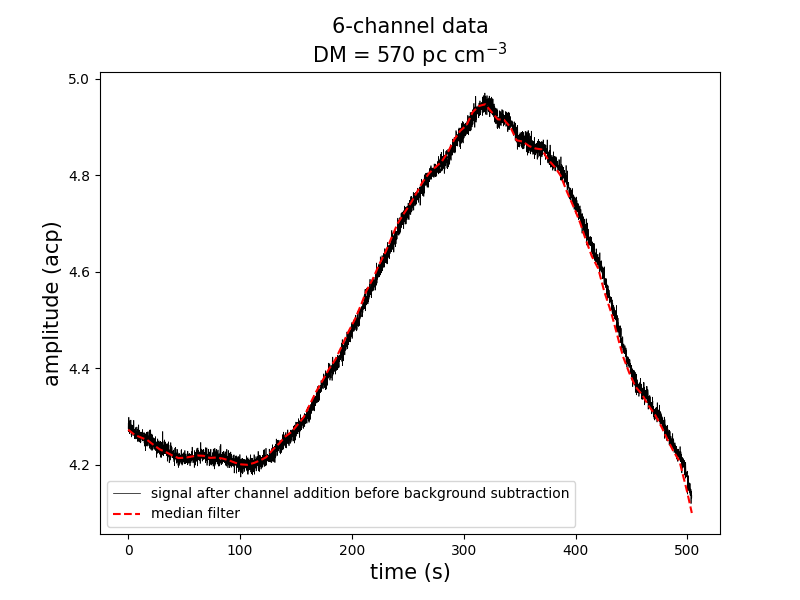

<IPython.core.display.Javascript object>


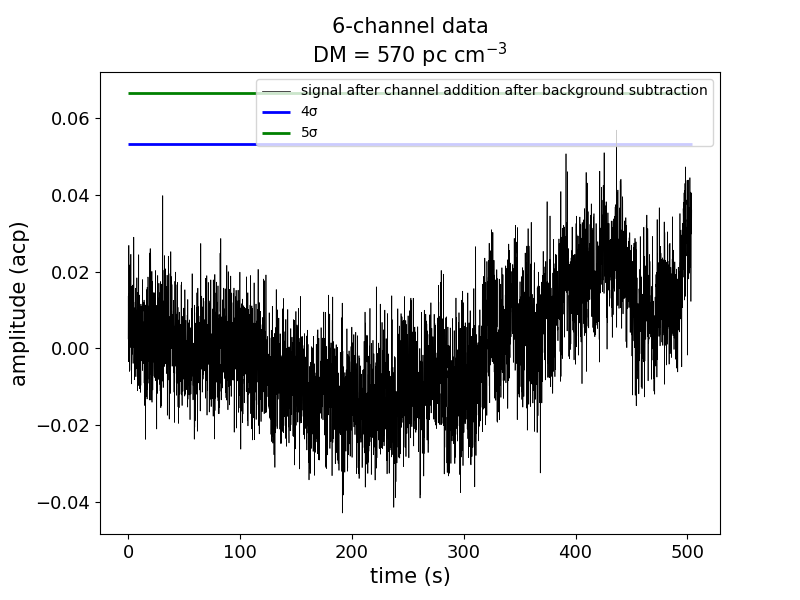

In [20]:
if DM == 0.247:
    step_background = int((0.63*1000/float(head['tresolution'][0]))*2)
if DM == 0.5700000000000001:
    step_background = int((2.8*1000/float(head['tresolution'][0]))*2)
 
if DM == 1.7670000000000001:

    step_background = int((33.3*1000/float(head['tresolution'][0]))*2)

if data_lenth == 'short':
    dm_ind = 300 #!!!!!!!!!!!!!!!!!
else: 
    dm_ind = 300*int(99/12.4928)
    
#step_background = 1000 #!!!!!!!!!!
 
print('Шаг медианного фильтра: ', step_background, ' точек')


point_time = point_time[dm_ind:]
summ_after_background = flatter(summ[dm_ind:], step_background, name = 'with DM', pic = True)
summ_wdm_after_background = flatter(summ_wdm[dm_ind:], step_background, name = 'without DM')

<IPython.core.display.Javascript object>


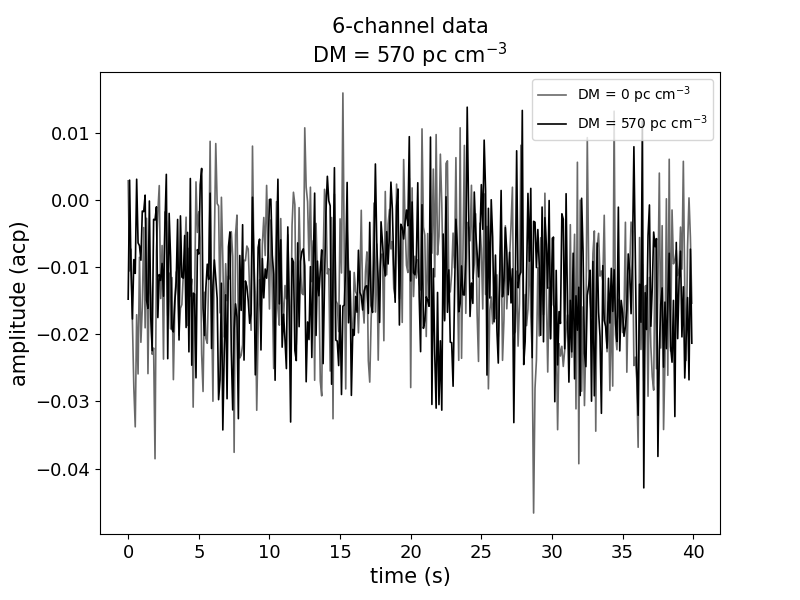

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

if data_lenth == 'long':
    time_ms = [i*12.4928/1000 for i in range(len(summ_wdm_after_background[i1: i2]))]
    name_ch = '32-channel data'
    
    """if DM == 247*10**-3:
        ax.arrow((fake_pulse)*12.4928/1000 - i1*12.4928/1000, summ_wdm_after_background [fake_pulse]+0.9, 0.0, -0.3, fc="k", ec="k", 
                 head_width=1, head_length=0.11, label = 'pulse', zorder = 5) #247

    if DM == 570*10**-3:

        ax.arrow((fake_pulse)*12/1000 - 0.23 - i1*12/1000, summ_wdm_after_background [fake_pulse]+1, 0.0, -0.3, fc="k", ec="k", 
                 head_width=1, head_length=0.07, label = 'pulse', zorder = 5) #570"""
    
else: 
    name_ch = '6-channel data'
    time_ms = [i*100/1000 for i in range(len(summ_wdm_after_background[i1:i2]))]
    
    """if DM == 570*10**-3:
        ax.arrow(((fake_pulse)*100/1000) - 0.09 - i1*100/1000, summ_wdm_after_background [fake_pulse]+1, 0.0, -0.2, fc="k", ec="k",
                 head_width=0.6, head_length=0.07, label = 'pulse', zorder = 5) #570
        
    if DM == 247*10**-3:
    
        ax.arrow(arrow_x-i1*100/1000 , summ_wdm_after_background [fake_pulse]+0.31, 0.0, -0.18, fc="k", ec="k", 
                 head_width=head_width, head_length=head_length, label = 'pulse', zorder = 5) #247"""
    
    
plt.title(name_ch + '\nDM = ' + str(round(DM*10**3)) + ' pc $\mathregular{cm^{-3}}$', size=15)
plt.plot(time_ms, summ_wdm_after_background[i1: i2], label = 'DM = 0' + ' pc $\mathregular{cm^{-3}}$', 
         color = 'dimgray', linewidth = 1.2)
plt.plot(time_ms, summ_after_background[i1: i2], label = 'DM = ' + str(round(DM*10**3)) + ' pc $\mathregular{cm^{-3}}$', color = 'black', linewidth = 1.2)

plt.ylabel('amplitude (acp)', size=15)
plt.xlabel('time (s)', size=15)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13)

plt.legend(loc='upper right')
name = ''
#plt.grid(True)
plt.show()

try:
    plt.savefig(path + 'after_' + name + '_' + str(DM*10**3) + '_' + name_ch + '_small.svg', dpi=500)
except:
    plt.savefig(path + 'after_' + name + '_'  + str(DM*10**3) + '_' + name_ch + '_small.svg', dpi=500)


## График с нулевой и ненулевой DM

<IPython.core.display.Javascript object>


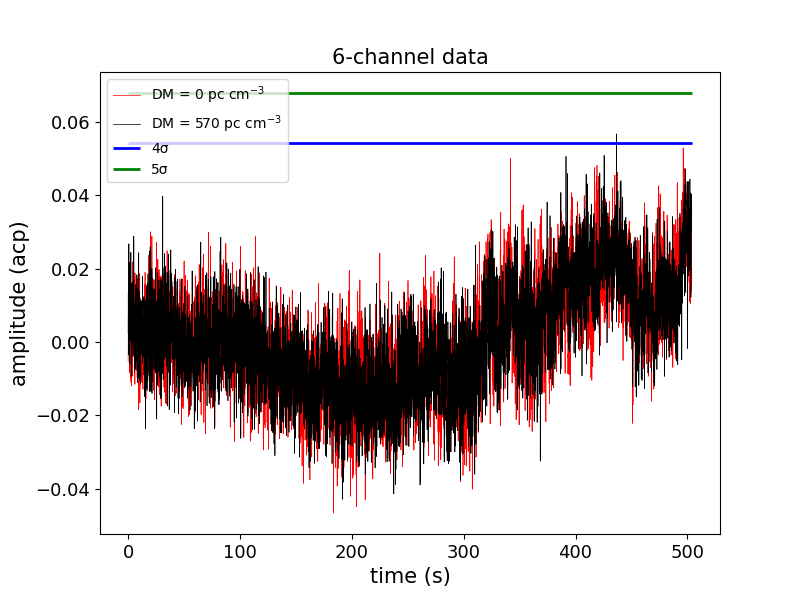

In [22]:
k = 9
i_1,i_2 = 0,len(summ_after_background)

n_dm_pic = summ_after_background[i_1:i_2]
n_wdm_pic = summ_wdm_after_background[i_1:i_2]

sigma_arrow = copy(n_wdm_pic) 
sigma_arrow.sort()
for_sigma = sigma_arrow[0:round(len(sigma_arrow)*0.95)]  


if data_lenth == 'long':
    name_ch = '32-channel data'
    time_ms = [i*12.4928/1000 for i in range(len(n_wdm_pic[i_1:i_2]))]
    
else: 
    name_ch = '6-channel data'
    time_ms = [i*100/1000 for i in range(len(n_wdm_pic[i_1:i_2]))]

fig, ax = plt.subplots(figsize=(8, 6))
plt.title(name_ch, size = 15)

if data_lenth == 'long':
    ax.hlines(np.std(for_sigma)*4, 0,len(time_ms)*12/1000 , color = 'blue', label = '4σ', linewidth = 2, zorder = 2)
    ax.hlines(np.std(for_sigma)*5, 0,len(time_ms)*12/1000 , color = 'green', label = '5σ', linewidth = 2, zorder = 2)
    
else: 
    ax.hlines(np.std(for_sigma)*4, 0,len(time_ms)*100/1000, color = 'blue', label = '4σ', linewidth = 2, zorder = 2)
    ax.hlines(np.std(for_sigma)*5, 0,len(time_ms)*100/1000, color = 'green', label = '5σ', linewidth = 2, zorder = 2)

"""if data_lenth == 'long':
    
    if DM == 247*10**-3:
        
        ax.arrow((fake_pulse)*12.4928/1000, n_wdm_pic[fake_pulse]+3, 0.0, -1.5, fc="k", ec="k",
                 head_width=16, head_length=0.8, label = 'pulse', zorder = 5) #247
        
    if DM == 570*10**-3:
        
        ax.arrow((fake_pulse)*12.4928/1000, n_wdm_pic[fake_pulse]+1, 0.0, -0.3, fc="k", ec="k", 
                 head_width=16, head_length=0.1, label = 'pulse', zorder = 5) #570
else:
    
    if DM == 570*10**-3:
    
        ax.arrow((fake_pulse)*100/1000 - 0.09, summ_after_background [fake_pulse]+0.8, 0.0, -0.2, fc="k", ec="k", 
                 head_width=8, head_length=0.07, label = 'pulse', zorder = 5) #570
        
    if DM == 247*10**-3:

        ax.arrow((fake_pulse)*100/1000, summ_after_background [fake_pulse]+0.7, 0.0, -0.3, fc="k", ec="k", 
                 head_width=18, head_length=0.2, label = 'pulse', zorder = 5) #247"""
    
plt.plot(time_ms, n_wdm_pic, label = 'DM = 0' + ' pc $\mathregular{cm^{-3}}$', color = 'red',linewidth = 0.5, zorder = 1)
plt.plot(time_ms, n_dm_pic,  label = 'DM = ' + str(round(DM*10**3)) + ' pc $\mathregular{cm^{-3}}$', color = 'black',linewidth = 0.5, zorder = 1)

plt.legend()
#plt.grid(True)

plt.ylabel('amplitude (acp)', size=15)
plt.xlabel('time (s)', size=15)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13)
                        
try:
    plt.savefig(path + 'with_and_without_dm_' + str(DM*10**3) + '_' + name_ch + '.svg', dpi=500)
except:
    plt.savefig(path + 'with_and_without_dm_' + str(DM*10**3) + '_' + name_ch + '.svg', dpi=500)
plt.show();

## Кросс-корреляция с шаблоном

### Кузьмин

#### Моделирование шаблона

In [23]:
if data_lenth == 'long':
    dm_comparison = 82*10**-3 
else: 
    dm_comparison = 333*10**-3
    

if DM <= dm_comparison:
    
    n = []
    for i in range(int(head['nbands'][0])):
        n.append((float((head['fbands'][i])[0:-1:]))**-2)

    t,t2 = [],[]
    for i in range(int(head['nbands'][0])):
        # в секундах
        t.append(abs((4.148808 * (10**6) * (n[len(n) - 1] - n[i]) * DM)))
    t.sort()    
    t_s = t[1]*1000  # в миллисекундах
    print('Уширение импульса в канале: ' , round(t_s), ' мс')

else: 
    
    t_s = scattering_kuz(DM)
    print('Уширение импульса по Кузьмину: ' , round(t_s), ' мс')

Уширение импульса по Кузьмину:  2761  мс


In [24]:
x = [i for i in range(-1,int(t_s)*10)]
x_scatter_kuz = scatter(x,t_s)

norm = 1/max(x_scatter_kuz)
for i in range (len((x_scatter_kuz))):
    x_scatter_kuz[i]*=norm

<IPython.core.display.Javascript object>


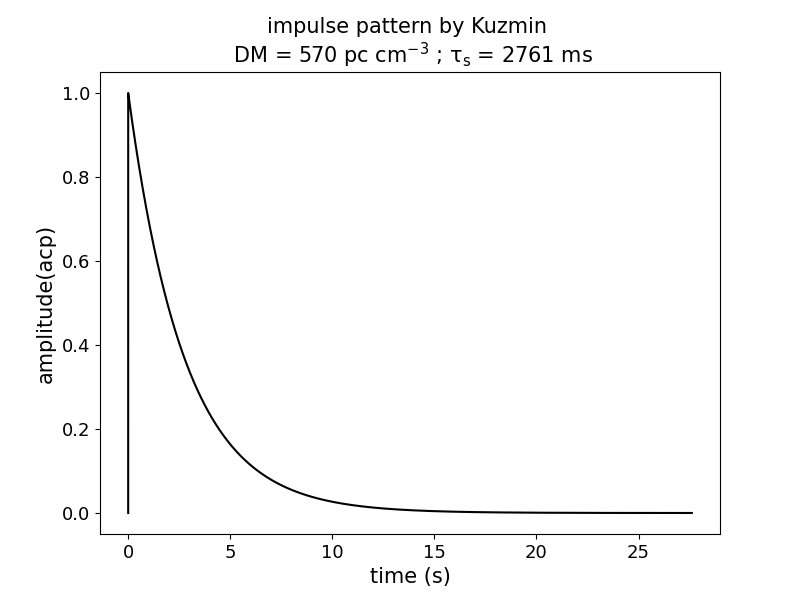

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title('impulse pattern by Kuzmin \n DM = ' + str(round(DM*10**3)) +
          ' pc $\mathregular{cm^{-3}}$ ; $\mathregular{τ_s}$ = ' + str(round(t_s)) + ' ms', size=15)

#ax.tick_params(axis='both', which='major', labelsize=10, length=5,
#               width=1)

time_plot = [i/1000 for i in x]

plt.plot(time_plot,  x_scatter_kuz, 'black')
#ax.grid(which='both', color='grey', linewidth=0.5, linestyle='--')
#plt.grid(True)
plt.ylabel('amplitude(acp)', size=15)
plt.xlabel('time (s)', size=15)
plt.show();
try:
    plt.savefig(path + 'pattern_kuzmin_' + str(DM*10**3) +  '_' + name_ch + '.svg', dpi=500)
except:
    plt.savefig(path + 'pattern_kuzmin_' + str(DM*10**3) + '_' + name_ch  + '.svg', dpi=500)

#### Кросс-корреляция 

In [26]:
if data_lenth == 'long':
    x = [i for i in range(-1,int(t_s/2))]
    x_scatter_kuz = scatter(x,t_s/12.5)    
else: 
    x = [i for i in range(-1,int(t_s/10))]
    x_scatter_kuz = scatter(x,t_s/100)

In [27]:
data_cut = summ_after_background
data_cut_wdm = summ_wdm_after_background

norm = 1/max(data_cut)
for i in range(len((data_cut))):
    data_cut[i] *= norm
    data_cut_wdm[i] *= norm

data_cut_after_background = data_cut
data_wdm_cut_after_background = data_cut_wdm
c = np.correlate(data_cut_after_background, x_scatter_kuz)
correlation = copy(c)

<IPython.core.display.Javascript object>


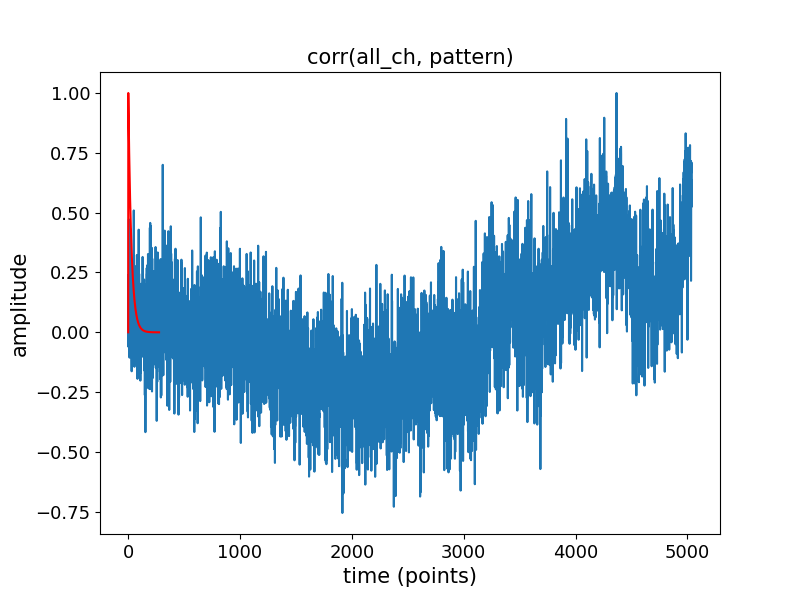

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title('corr(all_ch, pattern)', size=15)
plt.plot( x_scatter_kuz, 'r', zorder = 2)
plt.plot(data_cut_after_background,zorder = 1)
plt.ylabel('amplitude', size=15)
plt.xlabel('time (points)', size=15)
plt.show();

<IPython.core.display.Javascript object>


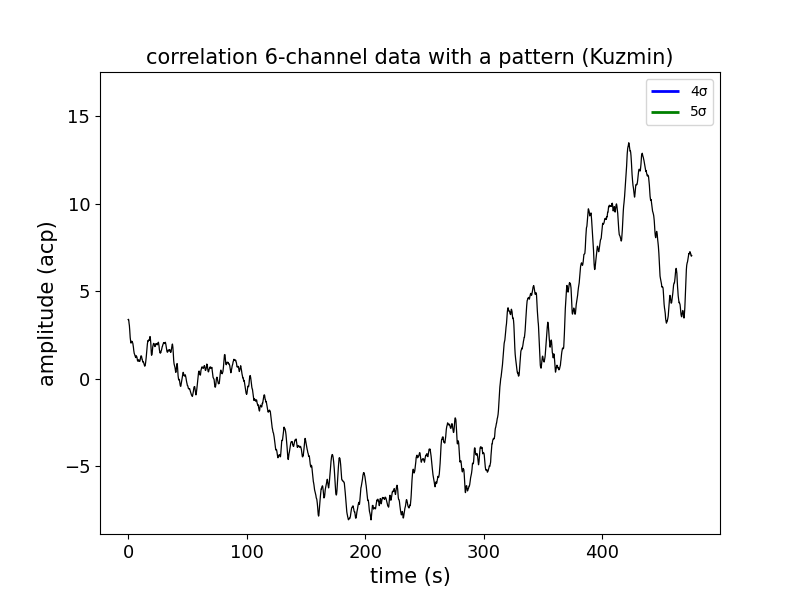

In [29]:
if data_lenth == 'long':
    step = 11*5
else:
    step = 11

c2 = moving_average(c,step)

sigma_arrow = copy(c2) 
sigma_arrow.sort()
for_sigma = sigma_arrow[0:round(len(sigma_arrow)*0.95)]  

if data_lenth == 'long':
    name_ch = '32-channel data'
    time_ms = [i*12.4928/1000 for i in range(len(c2))]
    
else: 
    name_ch = '6-channel data'
    time_ms = [i*100/1000 for i in range(len(c2))]

fig, ax = plt.subplots(figsize=(8, 6))

if data_lenth == 'long':
    ax.hlines(np.std(for_sigma)*4, 0,len(time_ms)*12/1000 , color = 'blue', label = '4σ', linewidth = 2, zorder = 2)
    ax.hlines(np.std(for_sigma)*5, 0,len(time_ms)*12/1000 , color = 'green', label = '5σ', linewidth = 2, zorder = 2)
    
else: 
    ax.hlines(np.std(for_sigma)*4, 0,len(time_ms)*100/1000, color = 'blue', label = '4σ', linewidth = 2, zorder = 2)
    ax.hlines(np.std(for_sigma)*5, 0,len(time_ms)*100/1000, color = 'green', label = '5σ', linewidth = 2, zorder = 2)
    
plt.title('correlation ' + str(name_ch) + ' with a pattern (Kuzmin)', size=15)
plt.plot(time_ms, c2, 'black', linewidth = 0.9)
plt.ylabel('amplitude (acp)', size=15)
plt.xlabel('time (s)', size=15)
#plt.grid(True)
plt.legend()
plt.ylim(min(c2)*1.1, max(c2)*1.3)
plt.show();
try:
    plt.savefig(path + 'corr_kuzmin_all' + str(int(DM*10**3)) + '_' + name_ch + '.svg', dpi=500)
except:
    plt.savefig(path + 'corr_kuzmin_all' + str(int(DM*10**3)) + '_' + name_ch + '.svg', dpi=500)

In [30]:
def flatter_512_corr(c2):

    def linear (x,a,b):
        return [a*i+b for i in x]

    if data_lenth == 'long':
        name_ch = '32-channel data'
        time_ms = [i*12.4928/1000 for i in range(len(c2))]

    else: 
        name_ch = '6-channel data'
        time_ms = [i*100/1000 for i in range(len(c2))]


    TREASHOLD1,TREASHOLD2,TREASHOLD3,TREASHOLD4 = int(1),int(1590), int(3030), int(4750)
    x1 = copy(list(time_ms[TREASHOLD1:TREASHOLD2]))
    y1 = copy(list(c2[TREASHOLD1:TREASHOLD2]))

    x2 = copy(list(time_ms[TREASHOLD2:TREASHOLD3]))
    y2 = copy(list(c2[TREASHOLD2:TREASHOLD3]))

    x3 = copy(list(time_ms[TREASHOLD3:TREASHOLD4]))
    y3 = copy(list(c2[TREASHOLD3:TREASHOLD4]))
    
    gmodel = Model(linear)
    result1 = gmodel.fit(y1, x=x1, a=1, b=1)
    result2 = gmodel.fit(y2, x=x2, a=1, b=1)
    result3 = gmodel.fit(y3, x=x3, a=1, b=1)


    popt1, pcov1 = curve_fit(linear, x1, y1)
    popt2, pcov2 = curve_fit(linear, x2, y2)
    popt3, pcov3 = curve_fit(linear, x3, y3)



    sub1 = [popt1[0]*i + popt1[1] for i in x1]
    sub2 = [popt2[0]*i + popt2[1] for i in x2]
    sub3 = [popt3[0]*i + popt3[1] for i in x3]
    
    
    if data_lenth == 'long':
        step = 11*5
    else:
        step = 11

    c2 = moving_average(c,step)

    sigma_arrow = copy(c2) 
    sigma_arrow.sort()
    for_sigma = sigma_arrow[0:round(len(sigma_arrow)*0.95)]  

    if data_lenth == 'long':
        name_ch = '32-channel data'
        time_ms = [i*12.4928/1000 for i in range(len(c2))]

    else: 
        name_ch = '6-channel data'
        time_ms = [i*100/1000 for i in range(len(c2))]

    fig, ax = plt.subplots(figsize=(8, 6))

    plt.plot(x1, result1.best_fit, 'r-', label='fit1', color = 'green', alpha = 0.8)
    plt.plot(x2, result2.best_fit, 'r-', label='fit2', color = 'blue', alpha = 0.8)
    plt.plot(x3, result3.best_fit, 'r-', label='fit3', color = 'orange', alpha = 0.8)
    
    plt.title('correlation ' + str(name_ch) + ' with a pattern (Kuzmin)', size=15)
    plt.plot(time_ms, c2, 'black', linewidth = 0.9)
    plt.ylabel('amplitude (acp)', size=15)
    plt.xlabel('time (s)', size=15)
    #plt.grid(True)
    plt.legend()
    plt.ylim(min(c2)*1.1, max(c2)*1.3)
    plt.show();
    try:
        plt.savefig(path + 'corr_kuzmin_all_fit' + str(int(DM*10**3)) + '_' + name_ch + '.svg', dpi=500)
    except:
        plt.savefig(path + 'corr_kuzmin_all_fit' + str(int(DM*10**3)) + '_' + name_ch + '.svg', dpi=500)
        
    after_sub1 = [y1[i] - sub1[i] for i in range(len(y1))]
    after_sub2 = [y2[i] - sub2[i] for i in range(len(y2))]
    after_sub3 = [y3[i] - sub3[i] for i in range(len(y3))]
    
    if data_lenth == 'long':
        step = 11*5
    else:
        step = 11

    c2 = moving_average(c,step)

    sigma_arrow = copy(c2) 
    sigma_arrow.sort()
    for_sigma = sigma_arrow[0:round(len(sigma_arrow)*0.95)]  

    if data_lenth == 'long':
        name_ch = '32-channel data'
        time_ms = [i*12.4928/1000 for i in range(len(c2))]

    else: 
        name_ch = '6-channel data'
        time_ms = [i*100/1000 for i in range(len(c2))]

    fig, ax = plt.subplots(figsize=(8, 6))

    plt.plot(x1, after_sub1, 'r-', color = 'black', alpha = 0.8)
    plt.plot(x2, after_sub2, 'r-', color = 'black', alpha = 0.8)
    plt.plot(x3, after_sub3, 'r-', color = 'black', alpha = 0.8)
    
    plt.title('correlation ' + str(name_ch) + ' with a pattern (Kuzmin)', size=15)
    #plt.plot(time_ms, c2, 'black', linewidth = 0.9)
    plt.ylabel('amplitude (acp)', size=15)
    plt.xlabel('time (s)', size=15)
    #plt.grid(True)
    plt.legend()
    plt.ylim(min(c2)*1.1, max(c2)*1.3)
    plt.show();
    try:
        plt.savefig(path + 'corr_kuzmin_all_fit_after' + str(int(DM*10**3)) + '_' + name_ch + '.svg', dpi=500)
    except:
        plt.savefig(path + 'corr_kuzmin_all_fit_after' + str(int(DM*10**3)) + '_' + name_ch + '.svg', dpi=500)
        
    return

<IPython.core.display.Javascript object>


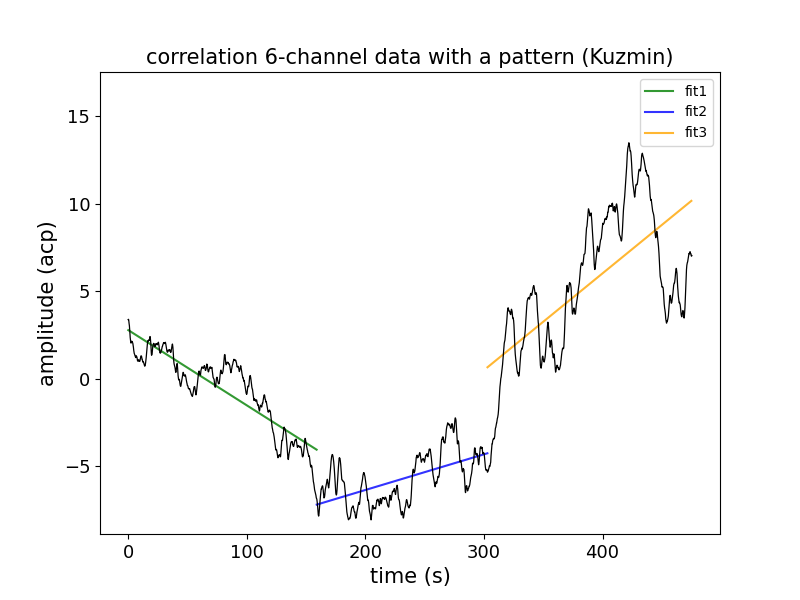

<IPython.core.display.Javascript object>


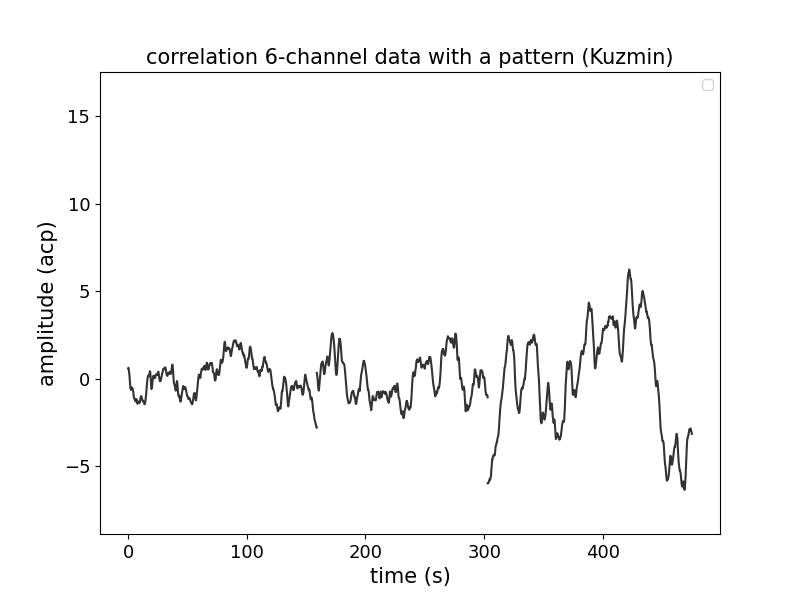

No handles with labels found to put in legend.


In [31]:
flatter_512_corr(c2)

In [32]:
def flatter_512_corr_poly(c2):

    def linear (x,a,b,c,d):
        return [a*i**3+b*i**2+c*i+d for i in x]

    if data_lenth == 'long':
        name_ch = '32-channel data'
        time_ms = [i*12.4928/1000 for i in range(len(c2))]

    else: 
        name_ch = '6-channel data'
        time_ms = [i*100/1000 for i in range(len(c2))]


    x = copy(list(time_ms))
    y = copy(list(c2))

    gmodel = Model(linear)
    result = gmodel.fit(y, x=x, a=1, b=1,c=1,d=1)
    popt, pcov = curve_fit(linear, x, y)

    sub = [popt[0]*x**3+popt[1]*x**2+popt[2]*x+popt[3] for x in x]
    
    
    if data_lenth == 'long':
        step = 11*5
    else:
        step = 11

    c2 = moving_average(c,step)

    sigma_arrow = copy(c2) 
    sigma_arrow.sort()
    for_sigma = sigma_arrow[0:round(len(sigma_arrow)*0.95)]  

    if data_lenth == 'long':
        name_ch = '32-channel data'
        time_ms = [i*12.4928/1000 for i in range(len(c2))]

    else: 
        name_ch = '6-channel data'
        time_ms = [i*100/1000 for i in range(len(c2))]

    fig, ax = plt.subplots(figsize=(8, 6))

    plt.plot(x, result.best_fit, 'r-', label='fit1', color = 'green', alpha = 0.8)
    
    plt.title('correlation ' + str(name_ch) + ' with a pattern (Kuzmin)', size=15)
    plt.plot(time_ms, c2, 'black', linewidth = 0.9)
    plt.ylabel('amplitude (acp)', size=15)
    plt.xlabel('time (s)', size=15)
    #plt.grid(True)
    plt.legend()
    plt.ylim(min(c2)*1.1, max(c2)*1.3)
    plt.show();
    try:
        plt.savefig(path + 'corr_kuzmin_all_fit' + str(int(DM*10**3)) + '_' + name_ch + '.svg', dpi=500)
    except:
        plt.savefig(path + 'corr_kuzmin_all_fit' + str(int(DM*10**3)) + '_' + name_ch + '.svg', dpi=500)
        
    after_sub = [y[i] - sub[i] for i in range(len(y))]
    
    if data_lenth == 'long':
        step = 11*5
    else:
        step = 11

    c2 = moving_average(c,step)

    sigma_arrow = copy(c2) 
    sigma_arrow.sort()
    for_sigma = sigma_arrow[0:round(len(sigma_arrow)*0.95)]  

    if data_lenth == 'long':
        name_ch = '32-channel data'
        time_ms = [i*12.4928/1000 for i in range(len(c2))]

    else: 
        name_ch = '6-channel data'
        time_ms = [i*100/1000 for i in range(len(c2))]

    fig, ax = plt.subplots(figsize=(8, 6))

    plt.plot(x, after_sub, 'r-', color = 'black', alpha = 0.8)
    
    plt.title('correlation ' + str(name_ch) + ' with a pattern (Kuzmin)', size=15)
    #plt.plot(time_ms, c2, 'black', linewidth = 0.9)
    plt.ylabel('amplitude (acp)', size=15)
    plt.xlabel('time (s)', size=15)
    #plt.grid(True)
    plt.legend()
    plt.ylim(min(c2)*1.1, max(c2)*1.3)
    plt.show();
    try:
        plt.savefig(path + 'corr_kuzmin_all_fit_after_poly' + str(int(DM*10**3)) + '_' + name_ch + '.svg', dpi=500)
    except:
        plt.savefig(path + 'corr_kuzmin_all_fit_after_poly' + str(int(DM*10**3)) + '_' + name_ch + '.svg', dpi=500)
        
    return

<IPython.core.display.Javascript object>


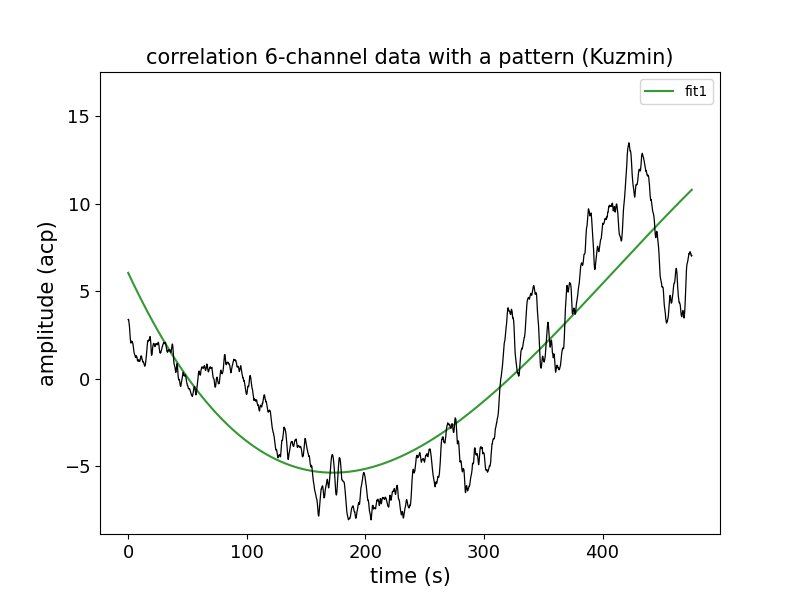

<IPython.core.display.Javascript object>


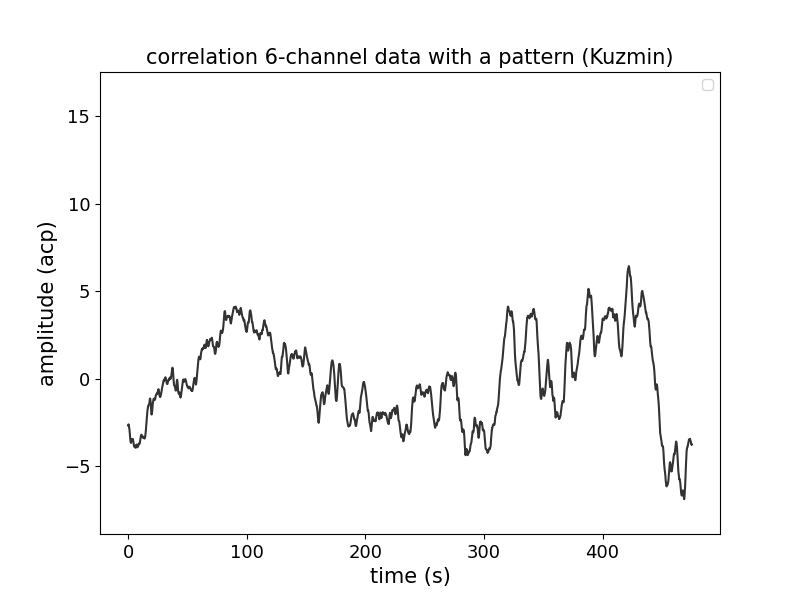

No handles with labels found to put in legend.


In [33]:
flatter_512_corr_poly(c2)

<IPython.core.display.Javascript object>


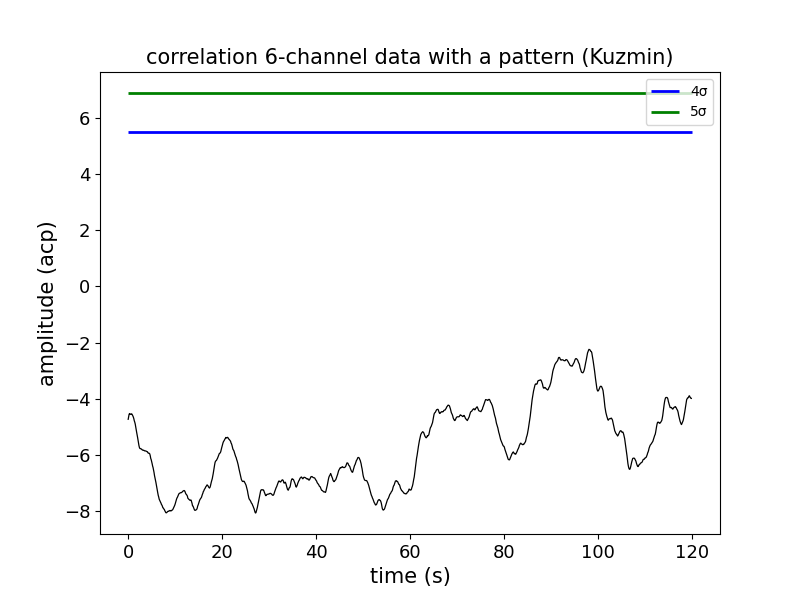

In [34]:
if data_lenth == 'long':
    c2_small = copy(c2[int(len(c2)/2 - 1*60*1000/12.4928):int(len(c2)/2 + 1*60*1000/12.4928)])
else:
    c2_small = copy(c2[int(len(c2)/2 - 1*60*1000/100):int(len(c2)/2 + 1*60*1000/100)])
    
sigma_arrow = copy(c2_small) 
sigma_arrow.sort()
for_sigma = sigma_arrow[0:round(len(sigma_arrow)*0.95)]  

if data_lenth == 'long':
    name_ch = '32-channel data'
    time_ms = [i*12.4928/1000 for i in range(len(c2_small))]
    
else: 
    name_ch = '6-channel data'
    time_ms = [i*100/1000 for i in range(len(c2_small))]

fig, ax = plt.subplots(figsize=(8, 6))

if data_lenth == 'long':
    ax.hlines(np.std(for_sigma)*4, 0,len(time_ms)*12/1000 , color = 'blue', label = '4σ', linewidth = 2, zorder = 2)
    ax.hlines(np.std(for_sigma)*5, 0,len(time_ms)*12/1000 , color = 'green', label = '5σ', linewidth = 2, zorder = 2)
    
else: 
    ax.hlines(np.std(for_sigma)*4, 0,len(time_ms)*100/1000, color = 'blue', label = '4σ', linewidth = 2, zorder = 2)
    ax.hlines(np.std(for_sigma)*5, 0,len(time_ms)*100/1000, color = 'green', label = '5σ', linewidth = 2, zorder = 2)
    
plt.title('correlation ' + str(name_ch) + ' with a pattern (Kuzmin)', size=15)
plt.plot(time_ms, c2_small, 'black', linewidth = 0.9)
plt.ylabel('amplitude (acp)', size=15)
plt.xlabel('time (s)', size=15)
#plt.grid(True)
plt.legend()
#plt.ylim(min(c2)*1.1, max(c2)*1.3)
plt.show();
try:
    plt.savefig(path + 'corr_kuzmin_2min' + str(int(DM*10**3)) + '_' + name_ch + '.svg', dpi=500)
except:
    plt.savefig(path + 'corr_kuzmin_2min' + str(int(DM*10**3)) + '_' + name_ch + '.svg', dpi=500)

<IPython.core.display.Javascript object>


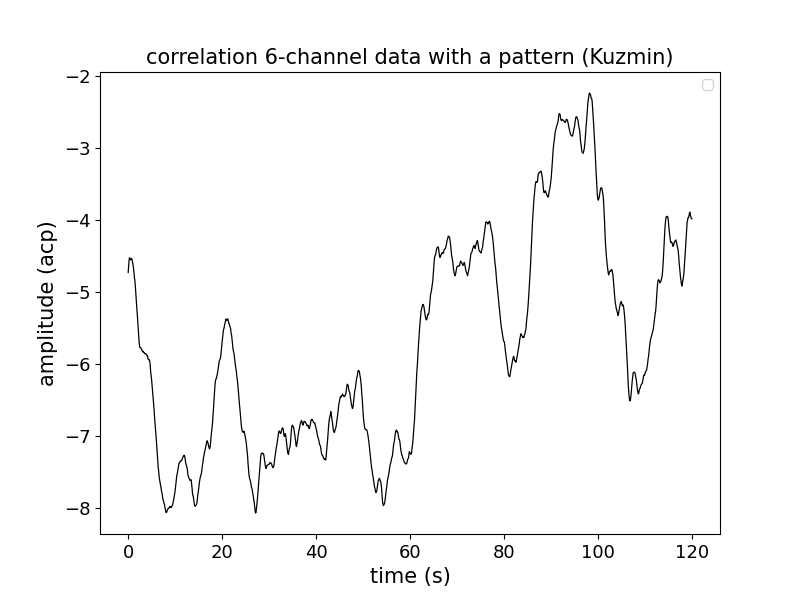

No handles with labels found to put in legend.


In [35]:
if data_lenth == 'long':
    c2_small = copy(c2[int(len(c2)/2 - 1*60*1000/12.4928):int(len(c2)/2 + 1*60*1000/12.4928)])
else:
    c2_small = copy(c2[int(len(c2)/2 - 1*60*1000/100):int(len(c2)/2 + 1*60*1000/100)])
    
sigma_arrow = copy(c2_small) 
sigma_arrow.sort()
for_sigma = sigma_arrow[0:round(len(sigma_arrow)*0.95)]  

if data_lenth == 'long':
    name_ch = '32-channel data'
    time_ms = [i*12.4928/1000 for i in range(len(c2_small))]
    
else: 
    name_ch = '6-channel data'
    time_ms = [i*100/1000 for i in range(len(c2_small))]

fig, ax = plt.subplots(figsize=(8, 6))

if data_lenth == 'long':
    a=1
    #ax.hlines(np.std(for_sigma)*4, 0,len(time_ms)*12/1000 , color = 'blue', label = '4σ', linewidth = 2, zorder = 2)
    #ax.hlines(np.std(for_sigma)*5, 0,len(time_ms)*12/1000 , color = 'green', label = '5σ', linewidth = 2, zorder = 2)
    
else: 
    a = 1
    #ax.hlines(np.std(for_sigma)*4, 0,len(time_ms)*100/1000, color = 'blue', label = '4σ', linewidth = 2, zorder = 2)
    #ax.hlines(np.std(for_sigma)*5, 0,len(time_ms)*100/1000, color = 'green', label = '5σ', linewidth = 2, zorder = 2)
    
plt.title('correlation ' + str(name_ch) + ' with a pattern (Kuzmin)', size=15)
plt.plot(time_ms, c2_small, 'black', linewidth = 0.9)
plt.ylabel('amplitude (acp)', size=15)
plt.xlabel('time (s)', size=15)
#plt.grid(True)
plt.legend()
#plt.ylim(min(c2)*1.1, max(c2)*1.3)
plt.show();
try:
    plt.savefig(path + 'corr_kuzmin_2min_' + str(int(DM*10**3)) + '_' + name_ch + '.svg', dpi=500)
except:
    plt.savefig(path + 'corr_kuzmin_2min_' + str(int(DM*10**3)) + '_' + name_ch + '.svg', dpi=500)

In [36]:
"""path2 = path + 'index/'
check_file = os.path.exists(path2)
if check_file == False:
    os.mkdir(path2)

for i in range(0, len(c2), 100):
    i_1 = i
    n = 350
    i_2 = i+n
    c3 = c2[i_1:i_2]
    #c3 = moving_average(c3,7)
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(c3, zorder=1, color='black')
    matplotlib.rc('xtick', labelsize=15)
    matplotlib.rc('ytick', labelsize=15)
    plt.title('cross-correlate data with a pattern', size=15)
    ax.grid(which='both', color='grey', linewidth=0.5, linestyle='--')
    plt.ylabel('amplitude', size=15)
    plt.xlabel('time (points)', size=15)
    try:
        plt.savefig(path2 + str(i_1) + ' - ' + str(i_2) + '.png', dpi=500);
        
        plt.close();
    except:
        plt.savefig(path2 + str(i_1) + ' - ' + str(i_2) + '.png', dpi=500);
        
        plt.close();"""

"path2 = path + 'index/'\ncheck_file = os.path.exists(path2)\nif check_file == False:\n    os.mkdir(path2)\n\nfor i in range(0, len(c2), 100):\n    i_1 = i\n    n = 350\n    i_2 = i+n\n    c3 = c2[i_1:i_2]\n    #c3 = moving_average(c3,7)\n    fig, ax = plt.subplots(figsize=(8, 6))\n    plt.plot(c3, zorder=1, color='black')\n    matplotlib.rc('xtick', labelsize=15)\n    matplotlib.rc('ytick', labelsize=15)\n    plt.title('cross-correlate data with a pattern', size=15)\n    ax.grid(which='both', color='grey', linewidth=0.5, linestyle='--')\n    plt.ylabel('amplitude', size=15)\n    plt.xlabel('time (points)', size=15)\n    try:\n        plt.savefig(path2 + str(i_1) + ' - ' + str(i_2) + '.png', dpi=500);\n        \n        plt.close();\n    except:\n        plt.savefig(path2 + str(i_1) + ' - ' + str(i_2) + '.png', dpi=500);\n        \n        plt.close();"

<IPython.core.display.Javascript object>


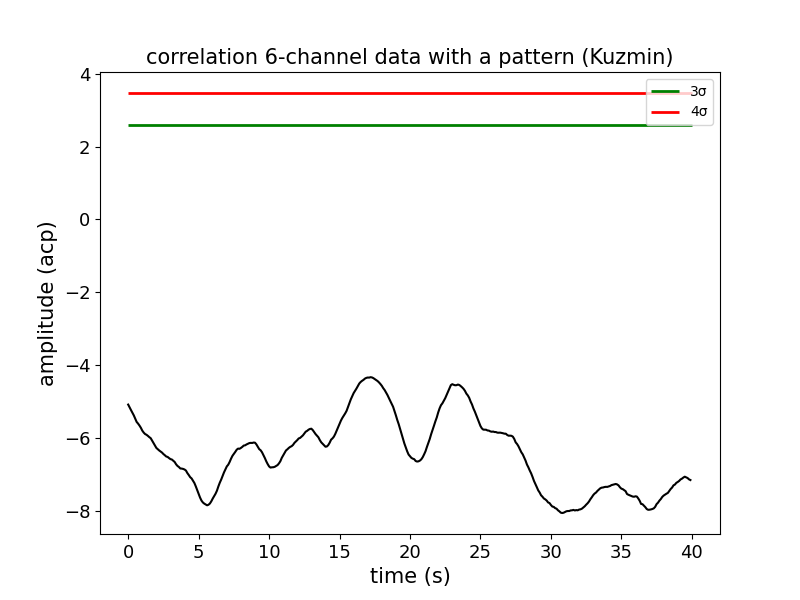

In [37]:
if data_lenth == 'long':
    step = 11*5
else:
    step = 11
c2 = moving_average(c,step)

#i1,i2 = 3248,3645
#i1,i2 = 0, len(c2)
sigma_arrow = copy(c2[i1:i2]) 
sigma_arrow.sort()
for_sigma = sigma_arrow[0:round(len(sigma_arrow)*0.9)]  
fig, ax = plt.subplots(figsize=(8, 6))

if data_lenth == 'long':
    name_ch = '32-channel data'
    time_ms = [i*12.4928/1000 for i in range(len(c2[i1:i2]))]
    arrow_x = fake_pulse*12.4928/1000
    ax.hlines(np.std(for_sigma)*3, 0,len(time_ms)*12/1000 , color = 'green', label = '3σ', linewidth = 2, zorder = 1)
    ax.hlines(np.std(for_sigma)*4, 0,len(time_ms)*12/1000 , color = 'red', label = '4σ', linewidth = 2, zorder = 1)

    
    
else: 
    name_ch = '6-channel data'
    time_ms = [i*100/1000 for i in range(len(c2[i1:i2]))]
    arrow_x = fake_pulse*100/1000
    ax.hlines(np.std(for_sigma)*3, 0,len(time_ms)*100/1000 , color = 'green', label = '3σ', linewidth = 2, zorder = 1)
    ax.hlines(np.std(for_sigma)*4, 0, len(time_ms)*100/1000, color = 'red', label = '4σ', linewidth = 2, zorder = 1)
    
#plt.grid(True, zorder = 0)

plt.title('correlation ' + str(name_ch) + ' with a pattern (Kuzmin)', size=15)
plt.plot(time_ms, c2[i1:i2], color = 'black')
plt.ylabel('amplitude (acp)', size=15)
plt.xlabel('time (s)', size=15)

if data_lenth == 'short':
    #ax.arrow(arrow_x-2-i1*100/1000, summ[fake_pulse]*0.15, 0.0, -0.5, fc="k", ec="k",head_width=1, head_length=0.25, label = 'pulse', zorder = 2)
    #ax.arrow(340.8, summ[fake_pulse]*0.075, 0.0, -0.06, fc="k", ec="k",head_width=1, head_length=0.05, label = 'pulse')
    #ax.arrow(600, summ[fake_pulse]*0.075, 0.0, -0.06, fc="k", ec="k",head_width=1, head_length=0.05, label = 'pulse')
    a=1
    
else:
    a=1
    #ax.arrow(fake_pulse/100, summ[fake_pulse]*0.029, 0.0, -0.2, fc="k", ec="k",head_width=0.1, head_length=0.07, label = 'pulse')

plt.legend()
plt.show();
try:
    plt.savefig(path + 'sigma_corr_kuzmin_' + str(int(DM*10**3)) + '_' + name_ch + '.svg', dpi=500)
except:
    plt.savefig(path + 'sigma_corr_kuzmin_' + str(int(DM*10**3)) + '_' + name_ch + '.svg', dpi=500)

<IPython.core.display.Javascript object>


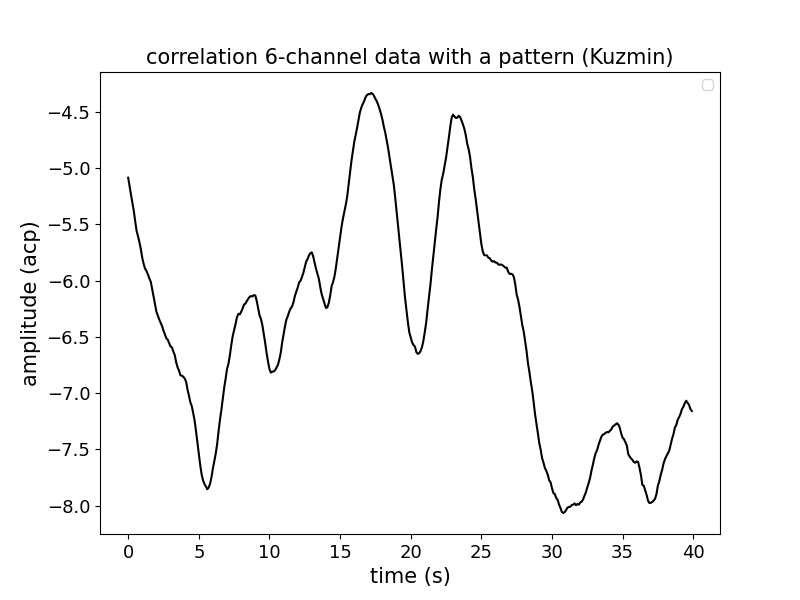

No handles with labels found to put in legend.


In [38]:
if data_lenth == 'long':
    step = 11*5
else:
    step =11
c2 = moving_average(c,step)

sigma_arrow = copy(c2[i1:i2]) 
sigma_arrow.sort()
for_sigma = sigma_arrow[0:round(len(sigma_arrow)*0.9)]  
fig, ax = plt.subplots(figsize=(8, 6))

if data_lenth == 'long':
    name_ch = '32-channel data'
    time_ms = [i*12.4928/1000 for i in range(len(c2[i1:i2]))]
    arrow_x = fake_pulse*12.4928/1000
    #ax.hlines(np.std(for_sigma)*3, 0,len(time_ms)*12/1000 , color = 'red', label = '3σ', linewidth = 2, zorder = 1)
    #ax.hlines(np.std(for_sigma)*4, 0,len(time_ms)*12/1000 , color = 'green', label = '4σ', linewidth = 2, zorder = 1)

    
    
else: 
    name_ch = '6-channel data'
    time_ms = [i*100/1000 for i in range(len(c2[i1:i2]))]
    arrow_x = fake_pulse*100/1000
    #ax.hlines(np.std(for_sigma)*3, 0,len(time_ms)*100/1000 , color = 'darkgray', label = '3σ', linewidth = 2, zorder = 1)
    #ax.hlines(np.std(for_sigma)*4, 0, len(time_ms)*100/1000, color = 'dimgray', label = '4σ', linewidth = 2, zorder = 1)
    
#plt.grid(True, zorder = 0)

plt.title('correlation ' + str(name_ch) + ' with a pattern (Kuzmin)', size=15)
plt.plot(time_ms, c2[i1:i2], color = 'black')
plt.ylabel('amplitude (acp)', size=15)
plt.xlabel('time (s)', size=15)

if data_lenth == 'short':
    #ax.arrow(arrow_x-2-i1*100/1000, summ[fake_pulse]*0.15, 0.0, -0.5, fc="k", ec="k",head_width=1, head_length=0.25, label = 'pulse', zorder = 2)
    #ax.arrow(340.8, summ[fake_pulse]*0.075, 0.0, -0.06, fc="k", ec="k",head_width=1, head_length=0.05, label = 'pulse')
    #ax.arrow(600, summ[fake_pulse]*0.075, 0.0, -0.06, fc="k", ec="k",head_width=1, head_length=0.05, label = 'pulse')
    a=1
    
else:
    a=1
    #ax.arrow(fake_pulse/100, summ[fake_pulse]*0.029, 0.0, -0.2, fc="k", ec="k",head_width=0.1, head_length=0.07, label = 'pulse')

plt.legend()
plt.show();
try:
    plt.savefig(path + 'corr_kuzmin_' + str(int(DM*10**3)) + '_' + name_ch + '.svg', dpi=500)
except:
    plt.savefig(path + 'corr_kuzmin_' + str(int(DM*10**3)) + '_' + name_ch + '.svg', dpi=500)

#### Координата события

In [39]:
c2 = list(c2)
summ_after_background = list(summ_after_background)
a2 = summ_after_background.index(summ_after_background[c2.index(max(c2[i1:i2]))])
print(a2)
a = number_of_points - abs(index1) 
a3 = (a+a2) - number_of_points

dt = TimeDelta(float(head['tresolution'][0])/1000, format='sec')
time_max = time_start + dt * (a3)

sidereal_time = my_sidereal_time(time_max, delta)

h = int(sidereal_time)
m = int((sidereal_time - int(sidereal_time))*60)
s =(((sidereal_time - int(sidereal_time))*60) - m)*60

print(h,m, round(s,4))

1722
5 19 3.7653


/home/oem/work/work/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [40]:
c2 = list(c2)
summ_after_background = list(summ_after_background)
a2 = summ_after_background.index(summ_after_background[c2.index(max(c2[i1:i2]))])

dt = TimeDelta(float(head['tresolution'][0])/1000, format='sec')
time_max = time_start + dt * (a2)

sidereal_time = my_sidereal_time(time_max, delta)

h = int(sidereal_time)
m = int((sidereal_time - int(sidereal_time))*60)
s =(((sidereal_time - int(sidereal_time))*60) - m)*60

print(h,m, round(s,4))

5 19 3.8116


In [41]:
c2 = list(c2)
summ_after_background = list(summ_after_background)

a2 = number_of_points - (number_of_points + abs(index1)) + fake_pulse
dt = TimeDelta(float(head['tresolution'][0])/1000, format='sec')
time_max = time_start + dt * (a2)

sidereal_time = my_sidereal_time(time_max, delta)

h = int(sidereal_time)
m = int((sidereal_time - int(sidereal_time))*60)
s =(((sidereal_time - int(sidereal_time))*60) - m)*60
print(h,'h ',m,'m ', round(s,4),'s')

5 h  19 m  3.8116 s


#### Сигнал шум события в данных

<IPython.core.display.Javascript object>


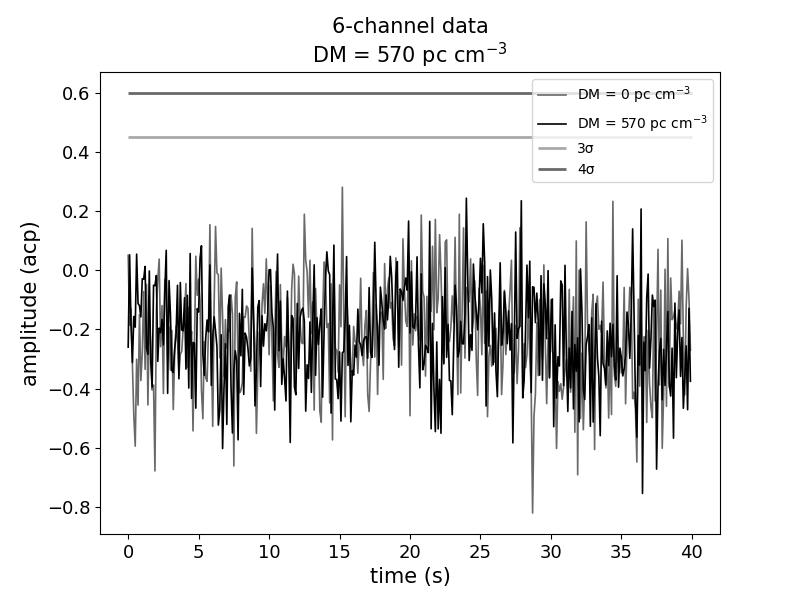

In [42]:
sigma_arrow = copy(summ_wdm_after_background[i1: i2]) 
sigma_arrow.sort()
for_sigma = sigma_arrow[0:round(len(sigma_arrow)*0.9)]  

fig, ax = plt.subplots(figsize=(8, 6))
head_width = 0.6
head_length = head_width/14



if data_lenth == 'long':
    time_ms = [i*12.4928/1000 for i in range(len(summ_wdm_after_background[i1: i2]))]
    name_ch = '32-channel data'
    
    """if DM == 570*10**-3:
        ax.arrow((fake_pulse)*12/1000-i1*12/1000 + 0.6, summ_wdm_after_background [fake_pulse]+1.7, 0.0, -0.3, fc="k", ec="k", 
                 head_width=1.4, head_length=0.1, label = 'pulse', zorder = 5) #570
    
    if DM == 247*10**-3:
        ax.arrow((fake_pulse)*12.4928/1000-i1*12.4928/1000, summ_wdm_after_background [fake_pulse]+1.1, 0.0, -0.3, fc="k", ec="k", 
                 head_width=1.4, head_length=0.1, label = 'pulse', zorder = 5) #247
    
    ax.hlines(np.std(for_sigma)*3, 0,len(time_ms)*12.4928/1000 , color = 'darkgray', label = '3σ', linewidth = 2, zorder = 1)
    ax.hlines(np.std(for_sigma)*4, 0, len(time_ms)*12.4928/1000, color = 'dimgray', label = '4σ', linewidth = 2, zorder = 1)"""
    
    
else: 
    name_ch = '6-channel data'
    time_ms = [i*100/1000 for i in range(len(summ_wdm_after_background[i1: i2]))]
    
    """if DM == 247*10**-3:
    
        ax.arrow(arrow_x-i1*100/1000 , summ_wdm_after_background [fake_pulse]+0.31, 0.0, -0.18, fc="k", ec="k", 
                 head_width=head_width, head_length=head_length, label = 'pulse', zorder = 5)
        
    if DM == 570*10**-3:
    
        ax.arrow(arrow_x-i1*100/1000 , summ_wdm_after_background [fake_pulse]+0.31, 0.0, -0.18, fc="k", ec="k", 
                 head_width=head_width, head_length=head_length, label = 'pulse', zorder = 5)"""
    
    ax.hlines(np.std(for_sigma)*3, 0,len(time_ms)*100/1000 , color = 'darkgray', label = '3σ', linewidth = 2, zorder = 1)
    ax.hlines(np.std(for_sigma)*4, 0, len(time_ms)*100/1000, color = 'dimgray', label = '4σ', linewidth = 2, zorder = 1)
    
    
    
plt.title(name_ch + '\nDM = ' + str(round(DM*10**3)) + ' pc $\mathregular{cm^{-3}}$', size=15)
plt.plot(time_ms, summ_wdm_after_background[i1: i2], label = 'DM = 0' + ' pc $\mathregular{cm^{-3}}$', 
         color = 'dimgray', linewidth = 1.2)
plt.plot(time_ms, summ_after_background[i1: i2], label = 'DM = ' + str(round(DM*10**3)) + ' pc $\mathregular{cm^{-3}}$', color = 'black', linewidth = 1.2)

plt.ylabel('amplitude (acp)', size=15)
plt.xlabel('time (s)', size=15)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13)

plt.legend(loc='upper right')
#plt.ylim([min(summ_wdm_after_background)*1.1, max(summ_wdm_after_background)*0.6])
name = ''
#plt.grid(True)
plt.show()

try:
    plt.savefig(path + 'after_sigma_' + str(DM*10**3) + '_' + name_ch + '_small.svg', dpi=500)
except:
    plt.savefig(path + 'after_sigma_' + str(DM*10**3) + '_' + name_ch + '_small.svg', dpi=500)

In [43]:
for_s = copy(summ_wdm_after_background[i1: i2])
sigma_arrow = copy(for_s) 
sigma_arrow.sort()
for_sigma = sigma_arrow[0:round(len(sigma_arrow)*0.9)]  
std = round(summ_after_background[fake_pulse]/np.std(for_sigma),3) #!!!!!!!!!!!!!!!!!!!
print('Сигнал шум события: ', std)

Сигнал шум события:  -1.415


<IPython.core.display.Javascript object>


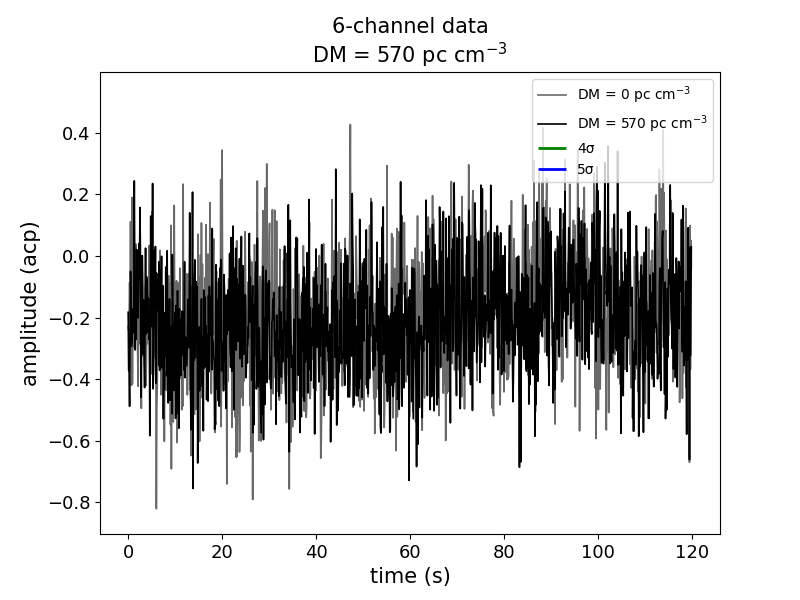

In [44]:
if data_lenth == 'long':
    data_small_dm = copy(summ_after_background[int(len(c2)/2 - 1*60*1000/12.4928):int(len(c2)/2 + 1*60*1000/12.4928)])
    data_small_wdm = copy(summ_wdm_after_background[int(len(c2)/2 - 1*60*1000/12.4928):int(len(c2)/2 + 1*60*1000/12.4928)])
    
else:
    data_small_dm = copy(summ_after_background[int(len(c2)/2 - 1*60*1000/100):int(len(c2)/2 + 1*60*1000/100)])
    data_small_wdm = copy(summ_wdm_after_background[int(len(c2)/2 - 1*60*1000/100):int(len(c2)/2 + 1*60*1000/100)])
    

sigma_arrow = copy(data_small_dm) 
sigma_arrow.sort()
for_sigma = sigma_arrow[0:round(len(sigma_arrow)*0.95)]  

fig, ax = plt.subplots(figsize=(8, 6))
head_width = 0.6
head_length = head_width/14

if data_lenth == 'long':
    time_ms = [i*12.4928/1000 for i in range(len(data_small_dm))]
    name_ch = '32-channel data'
    
    """if DM == 570*10**-3:
        ax.arrow((fake_pulse)*12/1000-i1*12/1000 + 0.6, summ_wdm_after_background [fake_pulse]+1.7, 0.0, -0.3, fc="k", ec="k", 
                 head_width=1.4, head_length=0.1, label = 'pulse', zorder = 5) #570
    
    if DM == 247*10**-3:
        ax.arrow((fake_pulse)*12.4928/1000-i1*12.4928/1000, summ_wdm_after_background [fake_pulse]+1.1, 0.0, -0.3, fc="k", ec="k", 
                 head_width=1.4, head_length=0.1, label = 'pulse', zorder = 5) #247
    
    ax.hlines(np.std(for_sigma)*3, 0,len(time_ms)*12.4928/1000 , color = 'darkgray', label = '3σ', linewidth = 2, zorder = 1)
    ax.hlines(np.std(for_sigma)*4, 0, len(time_ms)*12.4928/1000, color = 'dimgray', label = '4σ', linewidth = 2, zorder = 1)"""
    
    ax.hlines(np.std(for_sigma)*4, 0,len(time_ms)*12/1000 , color = 'green', label = '4σ', linewidth = 2, zorder = 1)
    ax.hlines(np.std(for_sigma)*5, 0, len(time_ms)*12/1000, color = 'blue', label = '5σ', linewidth = 2, zorder = 1)
      
else: 
    name_ch = '6-channel data'
    time_ms = [i*100/1000 for i in range(len(data_small_dm))]
    
    """if DM == 247*10**-3:
    
        ax.arrow(arrow_x-i1*100/1000 , summ_wdm_after_background [fake_pulse]+0.31, 0.0, -0.18, fc="k", ec="k", 
                 head_width=head_width, head_length=head_length, label = 'pulse', zorder = 5)
        
    if DM == 570*10**-3:
    
        ax.arrow(arrow_x-i1*100/1000 , summ_wdm_after_background [fake_pulse]+0.31, 0.0, -0.18, fc="k", ec="k", 
                 head_width=head_width, head_length=head_length, label = 'pulse', zorder = 5)"""
    
    ax.hlines(np.std(for_sigma)*4, 0,len(time_ms)*100/1000 , color = 'green', label = '4σ', linewidth = 2, zorder = 2)
    ax.hlines(np.std(for_sigma)*5, 0, len(time_ms)*100/1000, color = 'blue', label = '5σ', linewidth = 2, zorder = 2)
    plt.ylim(min(data_small_wdm)*1.1, max(data_small_wdm)*1.4)
    
plt.title(name_ch + '\nDM = ' + str(round(DM*10**3)) + ' pc $\mathregular{cm^{-3}}$', size=15)
plt.plot(time_ms, data_small_wdm, label = 'DM = 0' + ' pc $\mathregular{cm^{-3}}$', 
         color = 'dimgray', linewidth = 1.2, zorder = 1)
plt.plot(time_ms, data_small_dm, label = 'DM = ' + str(round(DM*10**3)) + ' pc $\mathregular{cm^{-3}}$', color = 'black', 
         linewidth = 1.2, zorder = 1)

plt.ylabel('amplitude (acp)', size=15)
plt.xlabel('time (s)', size=15)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13)

plt.legend(loc='upper right')
#plt.ylim([min(summ_wdm_after_background)*1.1, max(summ_wdm_after_background)*0.6])
name = ''
#plt.grid(True)
plt.show()

try:
    plt.savefig(path + 'after_sigma_2min' + str(DM*10**3) + '_' + name_ch + '_small.svg', dpi=500)
except:
    plt.savefig(path + 'after_sigma_2min' + str(DM*10**3) + '_' + name_ch + '_small.svg', dpi=500)

#### Сигнал шум события в кросc-корреляции

In [45]:
def difference_filtering(a, n=3):
    b = []
    for i in range(len(a)-n):
        b.append(a[i+n] - a[i])
    return b

<IPython.core.display.Javascript object>


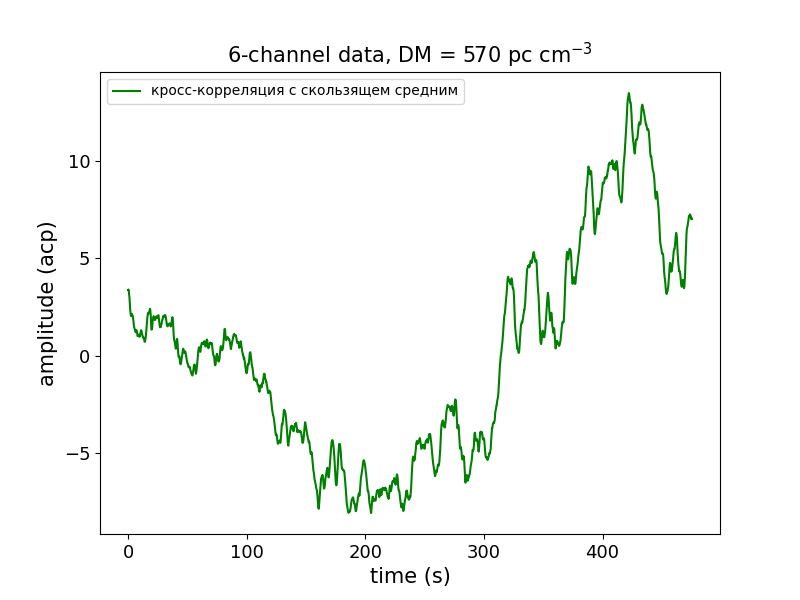

In [46]:
correlation_moving_arrange = moving_average(correlation, step)
correlation_difference = difference_filtering(correlation_moving_arrange, 448)
#correlation_difference = difference_filtering(correlation, 1)


fig, ax = plt.subplots(figsize=(8, 6))

plt.title(name_ch + ', DM = ' + str(round(DM*10**3)) + ' pc $\mathregular{cm^{-3}}$', size=15)

if data_lenth == 'long':
    
    time_ms = [i*12.4928/1000 for i in range(len(correlation_moving_arrange))]
    name_ch = '32-channel data'
    diff = len(time_ms) - len(correlation_moving_arrange) + 280
    
    """if DM == 570*10**-3:
        ax.arrow((fake_pulse)*12/1000-i1*12/1000 + 0.6, summ_wdm_after_background [fake_pulse]+1.7, 0.0, -0.3, fc="k", ec="k", 
                 head_width=1.4, head_length=0.1, label = 'pulse', zorder = 5) #570
    
    if DM == 247*10**-3:
        ax.arrow((fake_pulse)*12.4928/1000 - diff*12.4928/1000, summ_wdm_after_background [fake_pulse]+2.1, 0.0, -1.2, fc="k", ec="k", 
                 head_width=25, head_length=0.4, label = 'pulse', zorder = 5) #247
        
        plt.ylim(min(correlation)*1.4,max(correlation)*1.4)"""
    
    #ax.hlines(np.std(for_sigma)*3, 0,len(time_ms)*12.4928/1000 , color = 'darkgray', label = '3σ', linewidth = 2, zorder = 1)
    #ax.hlines(np.std(for_sigma)*4, 0, len(time_ms)*12.4928/1000, color = 'dimgray', label = '4σ', linewidth = 2, zorder = 1)
    
else: 
    name_ch = '6-channel data'
    time_ms = [i*100/1000 for i in range(len(correlation_moving_arrange))]
    
    """if DM == 247*10**-3:
    
        ax.arrow(arrow_x-i1*100/1000 , summ_wdm_after_background [fake_pulse]+0.31, 0.0, -0.18, fc="k", ec="k", 
                 head_width=head_width, head_length=head_length, label = 'pulse', zorder = 5)
        
    if DM == 570*10**-3:
    
        ax.arrow(arrow_x-i1*100/1000 , summ_wdm_after_background [fake_pulse]+0.31, 0.0, -0.18, fc="k", ec="k", 
                 head_width=head_width, head_length=head_length, label = 'pulse', zorder = 5)"""
    
    #ax.hlines(np.std(for_sigma)*3, 0,len(time_ms)*100/1000 , color = 'darkgray', label = '3σ', linewidth = 2, zorder = 1)
    #ax.hlines(np.std(for_sigma)*4, 0, len(time_ms)*100/1000, color = 'dimgray', label = '4σ', linewidth = 2, zorder = 1)
    
    
plt.ylabel('amplitude (acp)', size=15)
plt.xlabel('time (s)', size=15)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13)
 
#plt.plot(time_ms, correlation[:len(time_ms)], color = 'red', label = 'кросс-корреляция без фильтрации')
#plt.plot(time_ms[:len(correlation_difference)], correlation_difference,  color = 'navy', label = 'кросс-корреляция c разностным фильтром')
plt.plot(time_ms[:len(correlation_moving_arrange)], correlation_moving_arrange, color = 'green', label = 'кросс-корреляция с скользящем средним')

plt.legend()

In [47]:
"""if data_lenth == 'long' and cut_minute == 20:
        fake_pulse = int(3216*100/float(head['tresolution'][0]))

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(c[fake_pulse - int(100*100/float(head['tresolution'][0])):fake_pulse + int(100*100/float(head['tresolution'][0]))], 
         color = 'red', label = 'кросс-корреляция без фильтрации')
plt.plot(c4[fake_pulse - int(100*100/float(head['tresolution'][0])):fake_pulse + int(100*100/float(head['tresolution'][0]))],  
         color = 'navy', label = 'кросс-корреляция c фильтром')

plt.legend()"""

"if data_lenth == 'long' and cut_minute == 20:\n        fake_pulse = int(3216*100/float(head['tresolution'][0]))\n\nfig, ax = plt.subplots(figsize=(8, 6))\nplt.plot(c[fake_pulse - int(100*100/float(head['tresolution'][0])):fake_pulse + int(100*100/float(head['tresolution'][0]))], \n         color = 'red', label = 'кросс-корреляция без фильтрации')\nplt.plot(c4[fake_pulse - int(100*100/float(head['tresolution'][0])):fake_pulse + int(100*100/float(head['tresolution'][0]))],  \n         color = 'navy', label = 'кросс-корреляция c фильтром')\n\nplt.legend()"

In [48]:
print(np.std(for_sigma),correlation_moving_arrange[int(fake_pulse*12.4928/1000)])

0.15812957338890568 2.11769068173202


In [49]:
fake_pulse

1750

In [50]:
sigma_arrow = copy(correlation_moving_arrange) 
sigma_arrow.sort()
for_sigma = sigma_arrow[0:round(len(sigma_arrow)*0.9)]  
std = np.std(for_sigma)
print('Сигнал шум события(Кузьмин): ', round((c[int(fake_pulse)]/std),3))

Сигнал шум события(Кузьмин):  -1.411


### Бхат

#### Моделирование шаблона

In [51]:
a, b, c =  -6.59, 0.129, 1.02 #из стаьти Бхата
t_s = scattering_bhat_111(a, b, c, DM)
print('Уширение импульса по Бхату: ' , round(t_s), ' мс')

Уширение импульса по Бхату:  157509  мс


In [52]:
x = [i for i in range(-1,int(t_s/10))]
x_scatter_bhat = scatter(x,t_s/100)

norm = 1/max(x_scatter_bhat)
for i in range (len((x_scatter_bhat))):
    x_scatter_bhat[i]*=norm

<IPython.core.display.Javascript object>


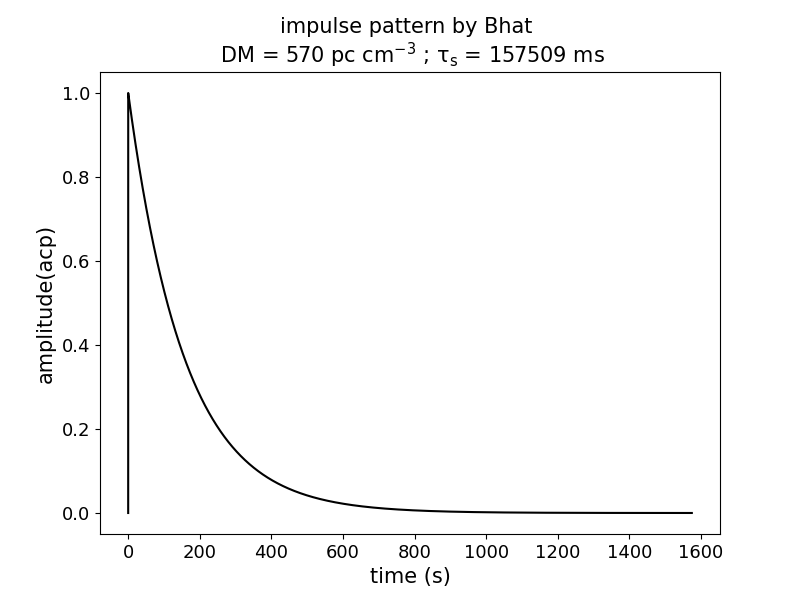

In [53]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title('impulse pattern by Bhat \n DM = ' + str(round(DM*10**3)) +
          ' pc $\mathregular{cm^{-3}}$ ; $\mathregular{τ_s}$ = ' + str(round(t_s)) + ' ms', size=15)

#ax.tick_params(axis='both', which='major', labelsize=10, length=5,
#               width=1)

time_plot = [i/10 for i in x]

plt.plot(time_plot,  x_scatter_bhat, 'black')
#ax.grid(which='both', color='grey', linewidth=0.5, linestyle='--')
#plt.grid(True)
plt.ylabel('amplitude(acp)', size=15)
plt.xlabel('time (s)', size=15)
plt.show();
try:
    plt.savefig(path + 'pattern_bhat_' + str(DM*10**3) + '_' + name_ch + '.svg', dpi=500)
except:
    plt.savefig(path + 'pattern_bhat_' + str(DM*10**3) + '_' + name_ch + '.svg', dpi=500)

#### Кросс-корреляция

In [54]:
data_cut = summ_after_background
norm = 1/max(data_cut)
for i in range(len((data_cut))):
    data_cut[i] *= norm

data_cut_after_background = data_cut
c = np.correlate(data_cut_after_background, x_scatter_bhat)

<IPython.core.display.Javascript object>


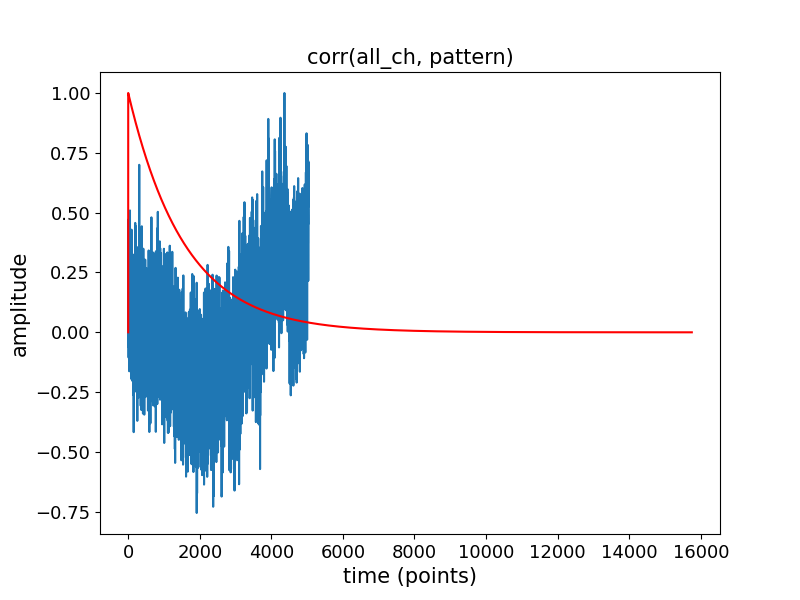

In [55]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title('corr(all_ch, pattern)', size=15)
plt.plot( x_scatter_bhat, 'r', zorder = 2)
plt.plot(data_cut_after_background,zorder = 1)
plt.ylabel('amplitude', size=15)
plt.xlabel('time (points)', size=15)
plt.show();

<IPython.core.display.Javascript object>


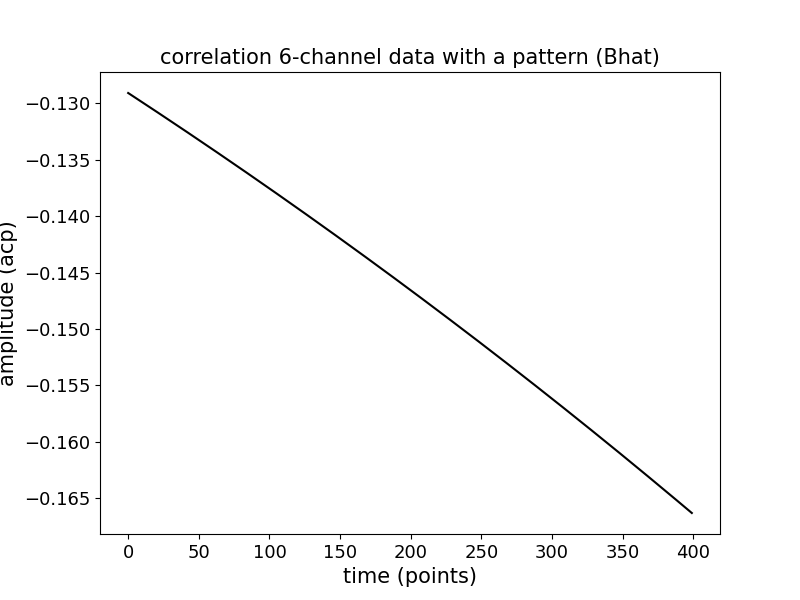

In [56]:
c2 = moving_average(c,11)
fig, ax = plt.subplots(figsize=(8, 6))
plt.title('correlation ' + str(name_ch) + ' with a pattern (Bhat)', size=15)
plt.plot(c2[i1:i2], 'black')
plt.ylabel('amplitude (acp)', size=15)
plt.xlabel('time (points)', size=15)
plt.show();
try:
    plt.savefig(path + 'corr_bhat_' + str(int(DM*10**3)) + '_' + name_ch + '.svg', dpi=500)
except:
    plt.savefig(path + 'corr_bhat_' + str(int(DM*10**3)) +  '_' + name_ch + '.svg', dpi=500)

#### Координата события 

In [57]:
c2 = list(c2)
summ_after_background = list(summ_after_background)
a2 = summ_after_background.index(summ_after_background[c2.index(max(c2[i1:i2]))])
print(a2)
a = number_of_points - abs(index1) 
a3 = (a+a2) - number_of_points

dt = TimeDelta(float(head['tresolution'][0])/1000, format='sec')
time_max = time_start + dt * (a3)

sidereal_time = my_sidereal_time(time_max, delta)

h = int(sidereal_time)
m = int((sidereal_time - int(sidereal_time))*60)
s =(((sidereal_time - int(sidereal_time))*60) - m)*60

print(h,m, round(s,4))

1550
5 18 3.3487


/home/oem/work/work/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [58]:
c2 = list(c2)
summ_after_background = list(summ_after_background)
a2 = summ_after_background.index(summ_after_background[c2.index(max(c2[i1:i2]))])

dt = TimeDelta(float(head['tresolution'][0])/1000, format='sec')
time_max = time_start + dt * (a2)

sidereal_time = my_sidereal_time(time_max, delta)

h = int(sidereal_time)
m = int((sidereal_time - int(sidereal_time))*60)
s =(((sidereal_time - int(sidereal_time))*60) - m)*60

print(h,m, round(s,4))

5 19 3.395


In [59]:
c2 = list(c2)
summ_after_background = list(summ_after_background)

a2 = number_of_points - (number_of_points + abs(index1)) + fake_pulse
dt = TimeDelta(float(head['tresolution'][0])/1000, format='sec')
time_max = time_start + dt * (a2)

sidereal_time = my_sidereal_time(time_max, delta)

h = int(sidereal_time)
m = int((sidereal_time - int(sidereal_time))*60)
s =(((sidereal_time - int(sidereal_time))*60) - m)*60
print(h,'h ',m,'m ', round(s,4),'s')

5 h  19 m  3.8116 s


#### Сигнал шум события в кросс-корреляции

<IPython.core.display.Javascript object>


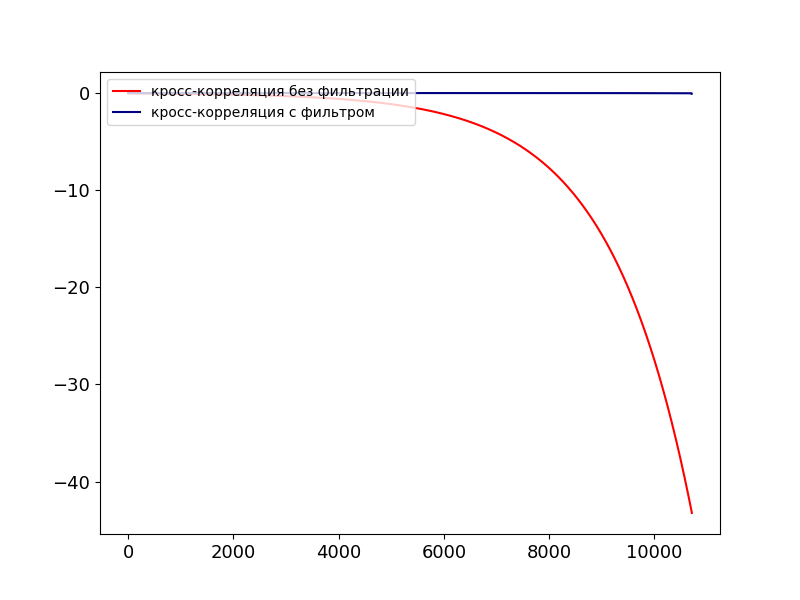

In [60]:
c4 = difference_filtering(c,1)
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(c, color = 'red', label = 'кросс-корреляция без фильтрации')
plt.plot(c4,  color = 'navy', label = 'кросс-корреляция c фильтром')
plt.legend(loc='upper left')

<IPython.core.display.Javascript object>


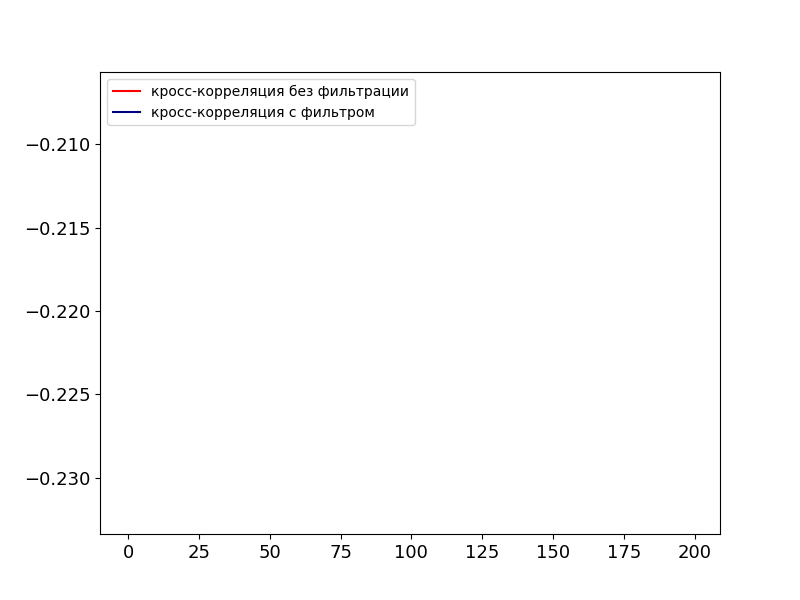

(-0.23337389421851218, -0.20567547553602022)

In [61]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(c[fake_pulse - int(100*100/float(head['tresolution'][0])):fake_pulse + int(100*100/float(head['tresolution'][0]))], 
         color = 'red', label = 'кросс-корреляция без фильтрации')
plt.plot(c4[fake_pulse - int(100*100/float(head['tresolution'][0])):fake_pulse + int(100*100/float(head['tresolution'][0]))],  
         color = 'navy', label = 'кросс-корреляция c фильтром')
plt.legend(loc='upper left')
plt.ylim(min(c[fake_pulse - int(100*100/float(head['tresolution'][0])):fake_pulse + int(100*100/float(head['tresolution'][0]))])*1.5,
         max(c[fake_pulse - int(100*100/float(head['tresolution'][0])):fake_pulse + int(100*100/float(head['tresolution'][0]))])*1.5)

In [62]:
for_s = copy(summ_wdm_after_background[i1: i2])
sigma_arrow = copy(for_s) 
sigma_arrow.sort()
for_sigma = sigma_arrow[0:round(len(sigma_arrow)*0.9)]  
std = round(summ_after_background[fake_pulse]/np.std(for_sigma),3) #!!!!!!!!!!!!!!!!!!!
print('Сигнал шум события: ', std)

Сигнал шум события:  -1.415


### Моделирование шаблона как у авторов 

In [63]:
x = [i for i in range(-1,int(t_s_from_article/10))]
x_scatter_what = scatter(x,t_s_from_article/100)

norm = 1/max(x_scatter_what)
for i in range (len((x_scatter_what))):
    x_scatter_what[i]*=norm

In [64]:
data_cut = summ_after_background
norm = 1/max(data_cut)
for i in range(len((data_cut))):
    data_cut[i] *= norm

data_cut_after_background = data_cut
c = np.correlate(data_cut_after_background, x_scatter_what)

<IPython.core.display.Javascript object>


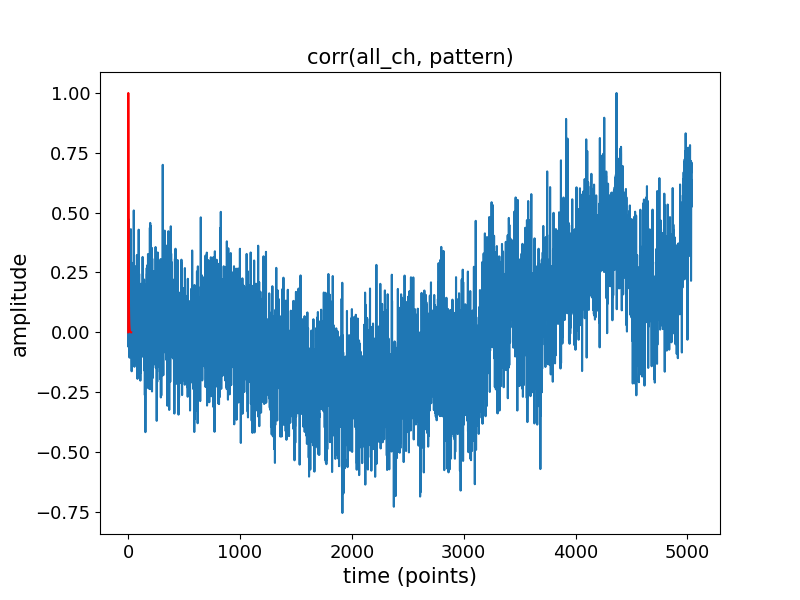

In [65]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title('corr(all_ch, pattern)', size=15)
plt.plot( x_scatter_what, 'r', zorder = 2)
plt.plot(data_cut_after_background,zorder = 1)
plt.ylabel('amplitude', size=15)
plt.xlabel('time (points)', size=15)
plt.show();

<IPython.core.display.Javascript object>


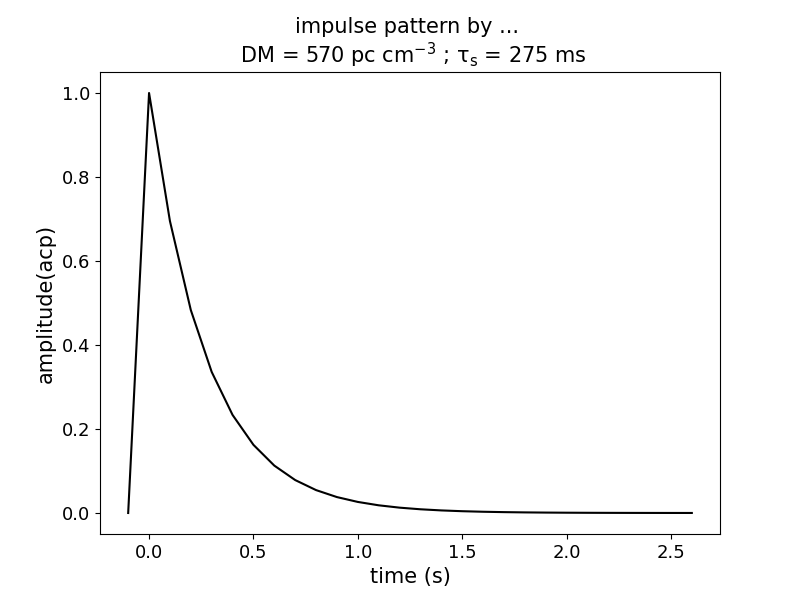

In [66]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title('impulse pattern by ... \n DM = ' + str(round(DM*10**3)) +
          ' pc $\mathregular{cm^{-3}}$ ; $\mathregular{τ_s}$ = ' + str(round(t_s_from_article)) + ' ms', size=15)

#ax.tick_params(axis='both', which='major', labelsize=10, length=5,
#               width=1)

time_plot = [i/10 for i in x]

plt.plot(time_plot,  x_scatter_what, 'black')
#ax.grid(which='both', color='grey', linewidth=0.5, linestyle='--')
#plt.grid(True)
plt.ylabel('amplitude(acp)', size=15)
plt.xlabel('time (s)', size=15)
plt.show();
try:
    plt.savefig(path + 'pattern_what_' + str(DM*10**3) + '_' + name_ch + '.svg', dpi=500)
except:
    plt.savefig(path + 'pattern_what_' + str(DM*10**3) + '_' + name_ch + '.svg', dpi=500)

<IPython.core.display.Javascript object>


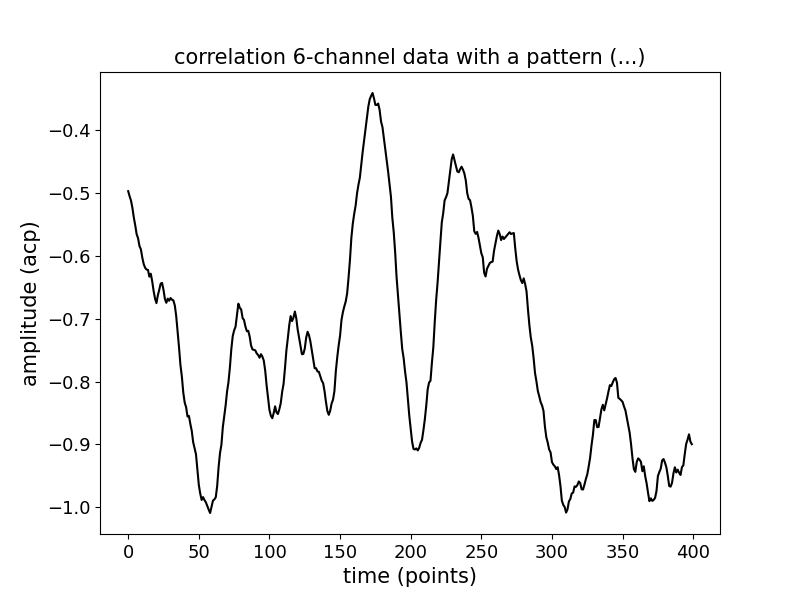

In [67]:
c2 = moving_average(c,28)
#c2 = moving_average(c,25)

fig, ax = plt.subplots(figsize=(8, 6))
plt.title('correlation ' + str(name_ch) + ' with a pattern (...)', size=15)
plt.plot(c2[i1:i2], 'black')
plt.ylabel('amplitude (acp)', size=15)
plt.xlabel('time (points)', size=15)
plt.show();
try:
    plt.savefig(path + 'corr_what_' + str(int(DM*10**3)) + '_' + name_ch + '.svg', dpi=500)
except:
    plt.savefig(path + 'corr_what_' + str(int(DM*10**3)) + '_' + name_ch + '.svg', dpi=500)

## Модели уширения импульсов 

### Уширение импульса в канале в зависимости от меры дисперсии

In [68]:
t_s_list_6_channel = []
dm_list = [i*10**-3 for i in range(3,2005)]
dm_list_plot = [i for i in range(3,2005)]

n = []
for i in range(int(head['nbands'][0])):
    n.append((float((head['fbands'][i])[0:-1:]))**-2)
    
for k in range (len(dm_list)):
    t,t2 = [],[]
    for i in range(int(head['nbands'][0])):
        # в секундах
        t.append(abs((4.148808 * (10**6) * (n[len(n) - 1] - n[i]) * dm_list[k])))
        
    t.sort() 
    t_s = t[1]*1000  # в миллисекундах
    t_s_list_6_channel.append(t_s)

In [69]:
try:
    head2 = read_head_pntr('/home/oem/work/files/170915_22_N2_00.pnthr')
except: 
    head2 = read_head_pntr('/home/elinxt/work/files/060617_15_N1_00.pnthr')
    

t_s_list_32_channel = []

n_32 = []
for i in range(int(head2['nbands'][0])):
    n_32.append((float((head2['fbands'][i])[0:-1:]))**-2)
    
for k in range (len(dm_list)):
    t_32,t2_32 = [],[]
    for i in range(int(head2['nbands'][0])):
        # в секундах
        t_32.append(abs((4.148808 * (10**6) * (n_32[len(n_32) - 1] - n_32[i]) * dm_list[k])))
        
    t_32.sort() 
    t_s_32 = t_32[1]*1000  # в миллисекундах
    t_s_list_32_channel.append(t_s_32)

### Модель уширения импульса по Кузьмину

In [70]:
t_s_list_kuz = []
dm_list = [i*10**-3 for i in range(3,2005)]
dm_list_plot = [i for i in range(3,2005)]

for i in range(len(dm_list)):
    dm = dm_list[i]
    t_s = scattering_kuz (dm)
    t_s_list_kuz.append(t_s)    

<IPython.core.display.Javascript object>


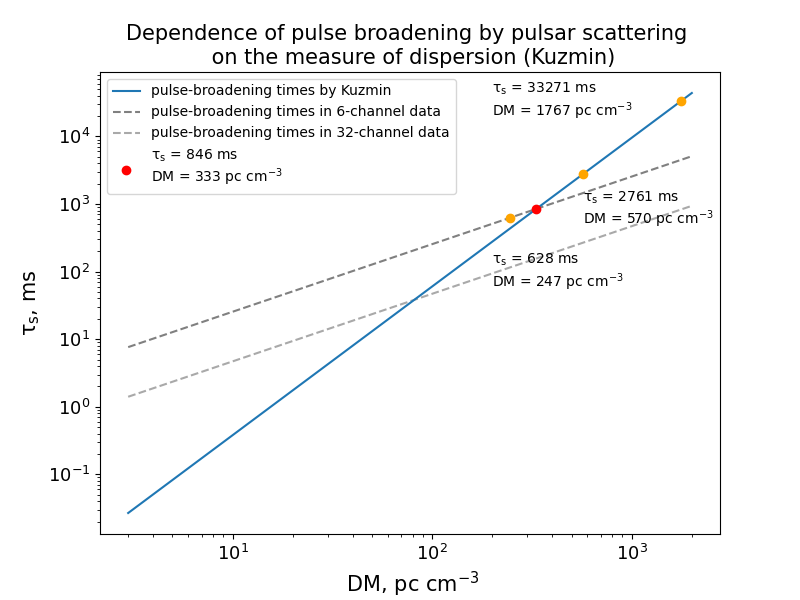

In [71]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(dm_list_plot, t_s_list_kuz, zorder=2,
         label='pulse-broadening times by Kuzmin')

plt.plot(dm_list_plot, t_s_list_6_channel, zorder=1, color='grey',
         linestyle='--', label='pulse-broadening times in 6-channel data')

plt.plot(dm_list_plot, t_s_list_32_channel, zorder=1, color='darkgray',
         linestyle='--', label='pulse-broadening times in 32-channel data')

ax.loglog()
plt.ylabel('$\mathregular{τ_s}$, ms', size=15)
plt.xlabel(' DM, pc $\mathregular{cm^{-3}}$', size=15)
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
plt.title('Dependence of pulse broadening by pulsar scattering \n on the measure of dispersion (Kuzmin)', size=15)
#ax.grid(which='both', color='grey', linewidth=0.5, linestyle='--')

plt.scatter(333, t_s_list_kuz[dm_list.index(333*10**-3)], color='red', zorder=3, label='$\mathregular{τ_s}$ = ' + str(
    round(t_s_list_kuz[dm_list.index(333*10**-3)])) + ' ms \nDM = ' + str(333) + ' pc $\mathregular{cm^{-3}}$')


plt.scatter(570,t_s_list_kuz[dm_list.index(570*10**-3)], color = 'orange', zorder=3)
plt.scatter(247,t_s_list_6_channel[dm_list.index(247*10**-3)], color = 'orange', zorder=3)
plt.scatter(1767,t_s_list_kuz[dm_list.index(1767*10**-3)], color = 'orange', zorder=3)

plt.text(200,60, '$\mathregular{τ_s}$ = ' + str(round(t_s_list_6_channel[dm_list.index(247*10**-3)])) +  ' ms \nDM = ' + str(247) + ' pc $\mathregular{cm^{-3}}$')
plt.text(570,500, '$\mathregular{τ_s}$ = ' + str(round(t_s_list_kuz[dm_list.index(570*10**-3)])) +  ' ms \nDM = ' + str(570) + ' pc $\mathregular{cm^{-3}}$')
plt.text(200,20000, '$\mathregular{τ_s}$ = ' + str(round(t_s_list_kuz[dm_list.index(1767*10**-3)])) +  ' ms \nDM = ' + str(1767) + ' pc $\mathregular{cm^{-3}}$')

plt.legend()
#plt.grid(True)

try:
    plt.savefig(path + 'scattering_kuzmin_' + name_ch + '.svg', dpi=500)
except:
    plt.savefig(path + 'scattering_kuzmin_' + name_ch + '.svg', dpi=500)
    
plt.show()

### Модель уширения по Бхату 

In [72]:
t_s_list = []
dm_list = [i*10**-3 for i in range(3,2005)]
dm_list_plot = [i for i in range(3,2005)]

a, b, c =  -6.59, 0.129, 1.02 #из стаьти Бхата
for i in range(len(dm_list)):
    dm = dm_list[i]
    t = scattering_bhat (a, b, c, dm)
    t_s_list.append(t)   

<IPython.core.display.Javascript object>


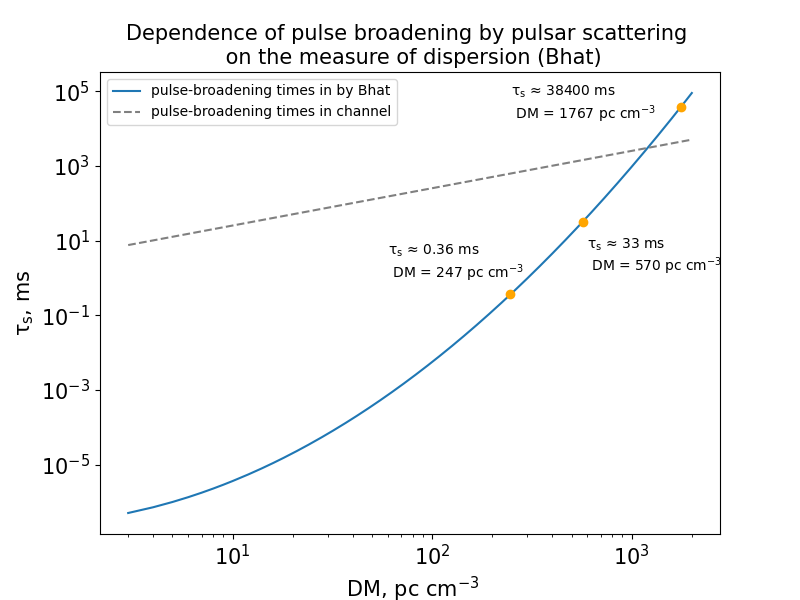

In [73]:
fig, ax = plt.subplots(figsize=(8, 6))

#plt.plot(t_s_list_kuz, zorder=2,
#         label='pulse-broadening times by Kuzmin')


plt.plot(dm_list_plot, t_s_list, zorder=1, label = 'pulse-broadening times in by Bhat')
plt.plot(dm_list_plot, t_s_list_6_channel, zorder=1, color = 'grey', linestyle = '--', label = 'pulse-broadening times in channel')
ax.loglog()
plt.ylabel('$\mathregular{τ_s}$, ms', size=15)
plt.xlabel(' DM, pc $\mathregular{cm^{-3}}$', size=15)
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
plt.title('Dependence of pulse broadening by pulsar scattering \n on the measure of dispersion (Bhat)', size=15)
#ax.grid(which='both', color='grey', linewidth=0.5, linestyle='--')
plt.scatter(570,t_s_list[dm_list.index(570*10**-3)], color = 'orange', zorder=2)
plt.scatter(247,t_s_list[dm_list.index(247*10**-3)], color = 'orange', zorder=2)
plt.scatter(1767,t_s_list[dm_list.index(1767*10**-3)], color = 'orange', zorder=2)

plt.text(600,1.5, '$\mathregular{τ_s}$ ≈ ' + str(round(t_s_list[dm_list.index(570*10**-3)])) +  ' ms \n DM = ' + str(570) + ' pc $\mathregular{cm^{-3}}$')
plt.text(60,1, '$\mathregular{τ_s}$ ≈ ' + str(round(t_s_list[dm_list.index(247*10**-3)], 2)) +  ' ms \n DM = ' + str(247) + ' pc $\mathregular{cm^{-3}}$')
plt.text(250,18000, '$\mathregular{τ_s}$ ≈ ' + str(round(t_s_list[dm_list.index(1767*10**-3)])) +  ' ms \n DM = ' + str(1767) + ' pc $\mathregular{cm^{-3}}$')
plt.legend()
#plt.grid(True)
try:
    plt.savefig(path + 'scattering_bhat.svg', dpi=500)
except:
    plt.savefig(path + 'scattering_bhat.svg', dpi=500)
    
plt.show();

In [74]:
t_s_list_111 = []
dm_list = [i*10**-3 for i in range(3,2005)]
dm_list_plot = [i for i in range(3,2005)]

a, b, c =  -6.59, 0.129, 1.02 #из стаьти Бхата
for i in range(len(dm_list)):
    dm = dm_list[i]
    t = scattering_bhat_111 (a, b, c, dm) 
    t_s_list_111.append(t)   

<IPython.core.display.Javascript object>


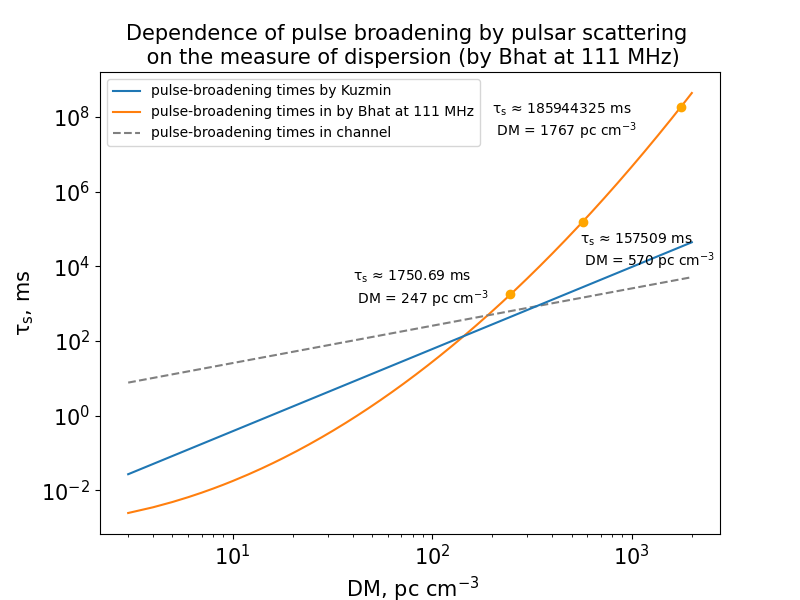

In [75]:
fig, ax = plt.subplots(figsize=(8, 6))


plt.plot(dm_list_plot, t_s_list_kuz, zorder=2,
         label='pulse-broadening times by Kuzmin')


plt.plot(dm_list_plot, t_s_list_111, zorder=1, label = 'pulse-broadening times in by Bhat at 111 MHz')
plt.plot(dm_list_plot, t_s_list_6_channel, zorder=1, color = 'grey', linestyle = '--', label = 'pulse-broadening times in channel')
ax.loglog()
plt.ylabel('$\mathregular{τ_s}$, ms', size=15)
plt.xlabel(' DM, pc $\mathregular{cm^{-3}}$', size=15)
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
plt.title('Dependence of pulse broadening by pulsar scattering \n on the measure of dispersion (by Bhat at 111 MHz)', size=15)
#ax.grid(which='both', color='grey', linewidth=0.5, linestyle='--')


plt.scatter(570,t_s_list_111[dm_list.index(570*10**-3)], color = 'orange', zorder=2)
plt.scatter(247,t_s_list_111[dm_list.index(247*10**-3)], color = 'orange', zorder=2)
plt.scatter(1767,t_s_list_111[dm_list.index(1767*10**-3)], color = 'orange', zorder=2)

plt.text(550,1*10**4, '$\mathregular{τ_s}$ ≈ ' + str(round(t_s_list_111[dm_list.index(570*10**-3)])) +  ' ms \n DM = ' + str(570) + ' pc $\mathregular{cm^{-3}}$')
plt.text(40,1000, '$\mathregular{τ_s}$ ≈ ' + str(round(t_s_list_111[dm_list.index(247*10**-3)], 2)) +  ' ms \n DM = ' + str(247) + ' pc $\mathregular{cm^{-3}}$')
plt.text(200,3*10**7, '$\mathregular{τ_s}$ ≈ ' + str(round(t_s_list_111[dm_list.index(1767*10**-3)])) +  ' ms \n DM = ' + str(1767) + ' pc $\mathregular{cm^{-3}}$')
plt.legend()
#plt.grid(True)

try:
    plt.savefig(path + 'scattering_bhat_111.svg', dpi=500)
except: 
    plt.savefig(path + 'scattering_bhat_111.svg', dpi=500)
    
plt.show();

## Рисунок со всеми найденныеми frb

In [76]:
numbers_freq = {'Apertif': (1370, 1), 'Arecibo': (1440, 2), 'ASCAP': (1297, 31), 'CHIME': (600, 29), 'UTMOST': (
    843, 8), 'Parkes': (1351, 27), 'FAST': (1750, 1), 'GBT': (1440, 1), 'VLA': (1440, 1), 'DSA-10': (1440, 1)}

In [77]:
frequency_all = [600, 843, 1297, 1351,1370, 1440, 1750]
number_all = [29, 8, 31, 27, 1, 5, 1]

<IPython.core.display.Javascript object>


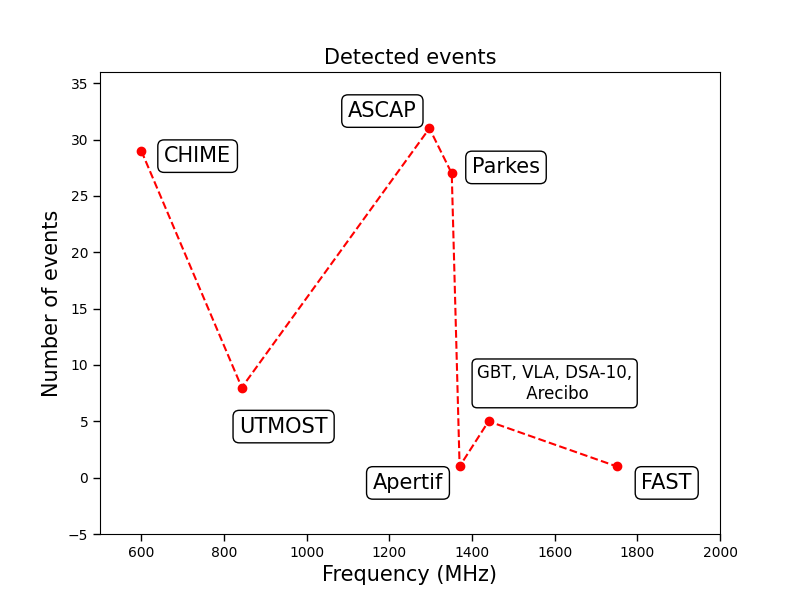

In [78]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title('Detected events', size=15)
ax.tick_params(axis='both', which='major', labelsize=10, length = 5,    #  Длинна делений
           width = 1)

plt.ylabel('$\mathregular{τ_s}$, ms', size=15)
plt.xlabel(' DM, pc $\mathregular{cm^{-3}}$', size=15)
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
#ax.grid(which='both', color='grey', linewidth=0.5, linestyle='--')
#plt.grid(True)
plt.plot(frequency_all, number_all, 'ro--')

plt.ylabel('Number of events', size=15)
plt.xlabel('Frequency (MHz)', size=15)

box_1 = {'facecolor':'white',    #  цвет области
       'edgecolor': 'black',     #  цвет крайней линии
       'boxstyle': 'round'} 

ax.text(655, 28, 'CHIME',
        bbox = box_1,
        color = 'black',    #  цвет шрифта
        fontsize = 15)

ax.text(837, 4, 'UTMOST',
        bbox = box_1,
        color = 'black',    #  цвет шрифта
        fontsize = 15)

ax.text(1100, 32, 'ASCAP',
        bbox = box_1,
        color = 'black',    #  цвет шрифта
        fontsize = 15)

ax.text(1400, 27, 'Parkes',
        bbox = box_1,
        color = 'black',    #  цвет шрифта
        fontsize = 15)

ax.text(1160, -1, 'Apertif',
        bbox = box_1,
        color = 'black',    #  цвет шрифта
        fontsize = 15)

ax.text(1600, 7, 'GBT, VLA, DSA-10,\n Arecibo',
        bbox = box_1,
        horizontalalignment = 'center',
        color = 'black',    #  цвет шрифта
        fontsize = 12)

ax.text(1810, -1, 'FAST',
        bbox = box_1,
        color = 'black',    #  цвет шрифта
        fontsize = 15)


ax.axis([500, 2000, -5, 36])
plt.show();
try:
    plt.savefig(path + 'all_frb.svg', dpi=500)
except:
    plt.savefig(path + 'all_frb.svg', dpi=500)